## Changing data into csv form

In [ ]:
# 别跑这一段，没有任何必要！！！！

import os, json, csv, gzip
from pathlib import Path

BASE = Path("data/m6Anet")
OUTDIR = Path("/mnt/sdd/fast/task2")
OUTDIR.mkdir(parents=True, exist_ok=True)

def iter_json_lines(path: Path):
    """Yield JSON objects from NDJSON file; supports .json and .json.gz."""
    if path.suffix == ".gz":
        opener = lambda: gzip.open(path, "rt", encoding="utf-8", errors="replace")
    else:
        opener = lambda: open(path, "r", encoding="utf-8")
    with opener() as f:
        for line in f:
            s = line.strip()
            if s:
                yield json.loads(s)

def flatten_record(rec):
    """
    Input record:
      { transcript_id : { position : { context7 : [ [9 features], ... ] } } }
    Yields rows: (transcript_id, position, context7, read_idx, 9 features)
    """
    (tid, tdata), = rec.items()
    (pos_key, contexts), = tdata.items()
    pos = int(pos_key) if isinstance(pos_key, str) else pos_key
    (ctx7, reads), = contexts.items()
    for i, fv in enumerate(reads):
        yield (
            tid, pos, ctx7, i,
            fv[0], fv[1], fv[2],
            fv[3], fv[4], fv[5],
            fv[6], fv[7], fv[8],
        )

HEADER = [
    "sample",
    "transcript_id","position","context7","read_idx",
    "dwell_m1","sd_m1","mean_m1",
    "dwell_0","sd_0","mean_0",
    "dwell_p1","sd_p1","mean_p1",
]

def process_sample_dir(sample_dir: Path):
    in_path = sample_dir / "data.json"
    sample_name = sample_dir.name
    out_path = OUTDIR / f"{sample_name}.csv"
    print(f"[write] {out_path}  <=  {in_path}")

    with open(out_path, "w", newline="", encoding="utf-8") as fout:
        w = csv.writer(fout)
        w.writerow(HEADER)
        for rec in iter_json_lines(in_path):
            for row in flatten_record(rec):
                w.writerow((sample_name, *row))

def main():
    if not BASE.exists():
        raise SystemExit(f"{BASE} not found")
    for p in sorted(BASE.iterdir()):
        if p.is_dir():
            process_sample_dir(p)

if __name__ == "__main__":
    main()


[write] /mnt/sdd/fast/task2/SGNex_A549_directRNA_replicate5_run1.csv  <=  data/m6Anet/SGNex_A549_directRNA_replicate5_run1/data.json
[write] /mnt/sdd/fast/task2/SGNex_A549_directRNA_replicate6_run1.csv  <=  data/m6Anet/SGNex_A549_directRNA_replicate6_run1/data.json
[write] /mnt/sdd/fast/task2/SGNex_Hct116_directRNA_replicate3_run1.csv  <=  data/m6Anet/SGNex_Hct116_directRNA_replicate3_run1/data.json
[write] /mnt/sdd/fast/task2/SGNex_Hct116_directRNA_replicate3_run4.csv  <=  data/m6Anet/SGNex_Hct116_directRNA_replicate3_run4/data.json
[write] /mnt/sdd/fast/task2/SGNex_Hct116_directRNA_replicate4_run3.csv  <=  data/m6Anet/SGNex_Hct116_directRNA_replicate4_run3/data.json
[write] /mnt/sdd/fast/task2/SGNex_HepG2_directRNA_replicate5_run2.csv  <=  data/m6Anet/SGNex_HepG2_directRNA_replicate5_run2/data.json
[write] /mnt/sdd/fast/task2/SGNex_HepG2_directRNA_replicate6_run1.csv  <=  data/m6Anet/SGNex_HepG2_directRNA_replicate6_run1/data.json
[write] /mnt/sdd/fast/task2/SGNex_K562_directRNA_repl

## Preprocessing the data exactly

In [ ]:
# 这一段也别跑，也没有任何必要！！！！

import os
from pathlib import Path
import polars as pl
from tqdm.auto import tqdm

os.environ["POLARS_MAX_THREADS"] = str(os.cpu_count())

IN_DIR  = Path("data/task2")
OUT_DIR = Path("data/processed_data")
OUT_DIR.mkdir(parents=True, exist_ok=True)

FEATURE_COLS = [
    "dwell_m1","sd_m1","mean_m1",
    "dwell_0","sd_0","mean_0",
    "dwell_p1","sd_p1","mean_p1",
]

def ctx_onehot_expr():
    exprs = []
    for i in range(7):
        ch = pl.col("context7").str.slice(i, 1).str.to_uppercase()
        for b in ("A","C","G","T"):
            exprs.append((ch == b).cast(pl.Int8).alias(f"ctx_{i*4 + 'ACGT'.index(b)}"))
    return exprs

def process_one_csv(in_path: Path, out_dir: Path = OUT_DIR, to_parquet: bool = False, drop_all_null_sites: bool = True):
    sample = in_path.stem

    scan = (
        pl.scan_csv(
            in_path,
            has_header=True,
            infer_schema_length=0,
            schema_overrides={
                "sample": pl.Utf8,
                "transcript_id": pl.Utf8,
                "position": pl.Int64,
                "context7": pl.Utf8,
            },
            null_values=[""],
        )
        .select(["sample","transcript_id","position","context7","read_idx", *FEATURE_COLS])
        .with_columns([pl.col(FEATURE_COLS).cast(pl.Float64, strict=False)])
    )

    keys = ["sample","transcript_id","position","context7"]

    aggs = []
    for c in FEATURE_COLS:
        aggs += [
            pl.col(c).mean().alias(f"mean_{c}"),
            pl.col(c).std(ddof=0).alias(f"std_{c}"),
            pl.col(c).min().alias(f"min_{c}"),
            pl.col(c).max().alias(f"max_{c}"),
            pl.col(c).median().alias(f"median_{c}"),
        ]
    aggs += [pl.len().alias("read_count")]

    site = (
        scan.group_by(keys).agg(aggs)
            .with_columns(ctx_onehot_expr())
            .collect()
    )

    out_path = (out_dir / f"{sample}_site_features.parquet") if to_parquet else (out_dir / f"{sample}_site_features.csv")
    (site.write_parquet(out_path) if to_parquet else site.write_csv(out_path))
    return sample, site.height, out_path

files = sorted(IN_DIR.glob("*.csv"))
print(f"Found {len(files)} files in {IN_DIR}")
results = []
for p in tqdm(files, desc="Processing files"):
    results.append(process_one_csv(p, OUT_DIR, to_parquet=False))
results


## Using model to predict

In [18]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
import joblib

IN_DIR     = Path("data/processed_data")
OUT_DIR    = Path("results")
META_PATH  = Path("models/metadata.json")
FOLDS_DIR  = Path("models/final")

OUT_DIR.mkdir(parents=True, exist_ok=True)

with META_PATH.open() as f:
    meta = json.load(f)
FEATURES  = meta["feature_names"]
THRESHOLD = meta.get("threshold", 0.5)

fold_paths = sorted(FOLDS_DIR.glob("xgb_fold*.pkl"))
if not fold_paths:
    raise FileNotFoundError(f"No fold models found in {FOLDS_DIR}")
models = [joblib.load(p) for p in fold_paths]
print(f"Loaded {len(models)} models: {[p.name for p in fold_paths]}")

def get_pos_series(df: pd.DataFrame) -> pd.Series:
    if "transcript_position" in df.columns:
        return df["transcript_position"]
    if "position" in df.columns:
        return df["position"].rename("transcript_position")
    raise KeyError("Need a 'transcript_position' or 'position' column in the input.")

for csv_path in sorted(IN_DIR.glob("*.csv")):
    print(f"[predict] {csv_path.name}")
    df = pd.read_csv(csv_path)

    missing = [c for c in FEATURES if c not in df.columns]
    if missing:
        raise KeyError(f"Missing expected feature columns in {csv_path.name}: {missing}")
    X = df[FEATURES].to_numpy()

    fold_probs = [m.predict_proba(X)[:, 1] for m in models]
    proba = np.mean(fold_probs, axis=0)

    out = pd.DataFrame({
        "transcript_id": df["transcript_id"],
        "transcript_position": get_pos_series(df),
        "score": proba,
    })

    out_path = OUT_DIR / f"{csv_path.stem}_scores.csv"
    out.to_csv(out_path, index=False)
    print(f"  -> wrote {out_path}")


Loaded 5 models: ['xgb_fold1.pkl', 'xgb_fold2.pkl', 'xgb_fold3.pkl', 'xgb_fold4.pkl', 'xgb_fold5.pkl']
[predict] SGNex_A549_directRNA_replicate5_run1_site_features.csv
  -> wrote results/SGNex_A549_directRNA_replicate5_run1_site_features_scores.csv
[predict] SGNex_A549_directRNA_replicate6_run1_site_features.csv
  -> wrote results/SGNex_A549_directRNA_replicate6_run1_site_features_scores.csv
[predict] SGNex_Hct116_directRNA_replicate3_run1_site_features.csv
  -> wrote results/SGNex_Hct116_directRNA_replicate3_run1_site_features_scores.csv
[predict] SGNex_Hct116_directRNA_replicate3_run4_site_features.csv
  -> wrote results/SGNex_Hct116_directRNA_replicate3_run4_site_features_scores.csv
[predict] SGNex_Hct116_directRNA_replicate4_run3_site_features.csv
  -> wrote results/SGNex_Hct116_directRNA_replicate4_run3_site_features_scores.csv
[predict] SGNex_HepG2_directRNA_replicate5_run2_site_features.csv
  -> wrote results/SGNex_HepG2_directRNA_replicate5_run2_site_features_scores.csv
[predic

### Data analysis

how did I analyse the data

In [2]:
import os
import re
import glob
import pandas as pd
from fastparquet import write as fp_write

DATA_DIR    = "data/processed_data"
FILE_GLOB   = "*.csv"
OUTPUT_DIR  = "data/processed_parquet"
CHUNK_SIZE  = 200_000

os.makedirs(OUTPUT_DIR, exist_ok=True)

SAMPLE_RE = re.compile(
    r"""^SGNex_
        (?P<cell_line>[A-Za-z0-9\-]+)
        _directRNA_
        replicate(?P<replicate>\d+)_
        run(?P<run>\d+)
        (?:_site_features)?$
    """,
    re.X,
)

def parse_sample_fields(sample_value: str):
    m = SAMPLE_RE.match(str(sample_value))
    if not m:
        return {"cell_line": None, "replicate": None, "run": None}
    return {
        "cell_line": m.group("cell_line"),
        "replicate": int(m.group("replicate")),
        "run": int(m.group("run")),
    }

def required_schema_guard(head_df: pd.DataFrame, csv_name: str):
    required_cols = {
        "sample","transcript_id","position","context7","read_count",
        "mean_dwell_m1","mean_sd_0","mean_mean_p1","ctx_0","ctx_27"
    }
    missing = [c for c in required_cols if c not in head_df.columns]
    if missing:
        raise ValueError(f"{csv_name} is missing columns: {missing}")

def normalize_chunk_types(chunk: pd.DataFrame) -> pd.DataFrame:
    for c in ("sample","transcript_id","context7"):
        if c in chunk.columns:
            chunk[c] = chunk[c].astype("string[python]")
    for c in ("position","read_count"):
        if c in chunk.columns:
            chunk[c] = pd.to_numeric(chunk[c], errors="coerce")
    return chunk

def write_parquet_append(df: pd.DataFrame, out_path: str, append: bool):
    df = df.convert_dtypes(dtype_backend="numpy_nullable")
    fp_write(out_path, df, compression="snappy", append=append)

def process_one_csv(csv_path: str):
    csv_name = os.path.basename(csv_path)

    head = pd.read_csv(csv_path, nrows=0)
    required_schema_guard(head, csv_name)

    out_parquet = os.path.join(
        OUTPUT_DIR,
        os.path.splitext(csv_name)[0] + ".parquet"
    )
    if os.path.exists(out_parquet):
        os.remove(out_parquet)

    total_rows = 0
    sample_val_first = None
    parsed_meta = None
    first_write_done = False

    for i, chunk in enumerate(pd.read_csv(csv_path, chunksize=CHUNK_SIZE)):
        if i == 0:
            sample_val_first = str(chunk["sample"].iloc[0])
            parsed_meta = parse_sample_fields(sample_val_first)

        chunk = chunk.assign(
            cell_line=parsed_meta["cell_line"],
            replicate=parsed_meta["replicate"],
            run=parsed_meta["run"],
            source_file=csv_name,
        )

        chunk = normalize_chunk_types(chunk)

        write_parquet_append(chunk, out_parquet, append=first_write_done)
        first_write_done = True
        total_rows += len(chunk)

    return {
        "source_file": csv_name,
        "parquet_path": out_parquet,
        "sample": sample_val_first,
        "cell_line": parsed_meta["cell_line"],
        "replicate": parsed_meta["replicate"],
        "run": parsed_meta["run"],
        "n_sites": total_rows,
    }

def main():
    files = sorted(glob.glob(os.path.join(DATA_DIR, FILE_GLOB)))
    if not files:
        raise FileNotFoundError(f"No files matched {os.path.join(DATA_DIR, FILE_GLOB)}")

    print(f"Found {len(files)} files. Writing Parquet files to: {OUTPUT_DIR}")
    summaries = []

    for fp in files:
        print(f"\nProcessing: {fp}")
        meta = process_one_csv(fp)
        print(f"  -> rows: {meta['n_sites']}, sample: {meta['sample']}")
        print(f"  -> wrote: {meta['parquet_path']}")
        summaries.append(meta)

    out_summary = os.path.join(os.path.dirname(OUTPUT_DIR), "samples.csv")
    pd.DataFrame(summaries).sort_values(
        ["cell_line","replicate","run","source_file"]
    ).to_csv(out_summary, index=False)

    manifest_path = os.path.join(os.path.dirname(OUTPUT_DIR), "processed_manifest.txt")
    with open(manifest_path, "w") as f:
        for m in summaries:
            f.write(m["parquet_path"] + "\n")

    print("\nDONE.")
    print(f"Per-file summary: {out_summary}")
    print(f"Manifest:         {manifest_path}")
    print("\nLoad later (pandas):")
    print("  import glob, pandas as pd")
    print(f"  files = glob.glob(r'{OUTPUT_DIR}/*.parquet')")
    print("  df = pd.concat((pd.read_parquet(p) for p in files), ignore_index=True)")
    print("\nOr load lazily with DuckDB (very RAM-friendly):")
    print("  import duckdb")
    print(f"  con = duckdb.connect()")
    print(f"  df = con.execute(\"SELECT * FROM parquet_scan('{OUTPUT_DIR}/*.parquet')\").df()")

if __name__ == "__main__":
    main()


Found 12 files. Writing Parquet files to: data/processed_parquet

Processing: data/processed_data/SGNex_A549_directRNA_replicate5_run1_site_features.csv
  -> rows: 1008933, sample: SGNex_A549_directRNA_replicate5_run1
  -> wrote: data/processed_parquet/SGNex_A549_directRNA_replicate5_run1_site_features.parquet

Processing: data/processed_data/SGNex_A549_directRNA_replicate6_run1_site_features.csv
  -> rows: 1500579, sample: SGNex_A549_directRNA_replicate6_run1
  -> wrote: data/processed_parquet/SGNex_A549_directRNA_replicate6_run1_site_features.parquet

Processing: data/processed_data/SGNex_Hct116_directRNA_replicate3_run1_site_features.csv
  -> rows: 1391230, sample: SGNex_Hct116_directRNA_replicate3_run1
  -> wrote: data/processed_parquet/SGNex_Hct116_directRNA_replicate3_run1_site_features.parquet

Processing: data/processed_data/SGNex_Hct116_directRNA_replicate3_run4_site_features.csv
  -> rows: 1302514, sample: SGNex_Hct116_directRNA_replicate3_run4
  -> wrote: data/processed_parq

Found 12 parquet files.
Processing: data/processed_parquet/SGNex_A549_directRNA_replicate5_run1_site_features.parquet
Processing: data/processed_parquet/SGNex_A549_directRNA_replicate6_run1_site_features.parquet
Processing: data/processed_parquet/SGNex_Hct116_directRNA_replicate3_run1_site_features.parquet
Processing: data/processed_parquet/SGNex_Hct116_directRNA_replicate3_run4_site_features.parquet
Processing: data/processed_parquet/SGNex_Hct116_directRNA_replicate4_run3_site_features.parquet
Processing: data/processed_parquet/SGNex_HepG2_directRNA_replicate5_run2_site_features.parquet
Processing: data/processed_parquet/SGNex_HepG2_directRNA_replicate6_run1_site_features.parquet
Processing: data/processed_parquet/SGNex_K562_directRNA_replicate4_run1_site_features.parquet
Processing: data/processed_parquet/SGNex_K562_directRNA_replicate5_run1_site_features.parquet
Processing: data/processed_parquet/SGNex_K562_directRNA_replicate6_run1_site_features.parquet
Processing: data/processed_p

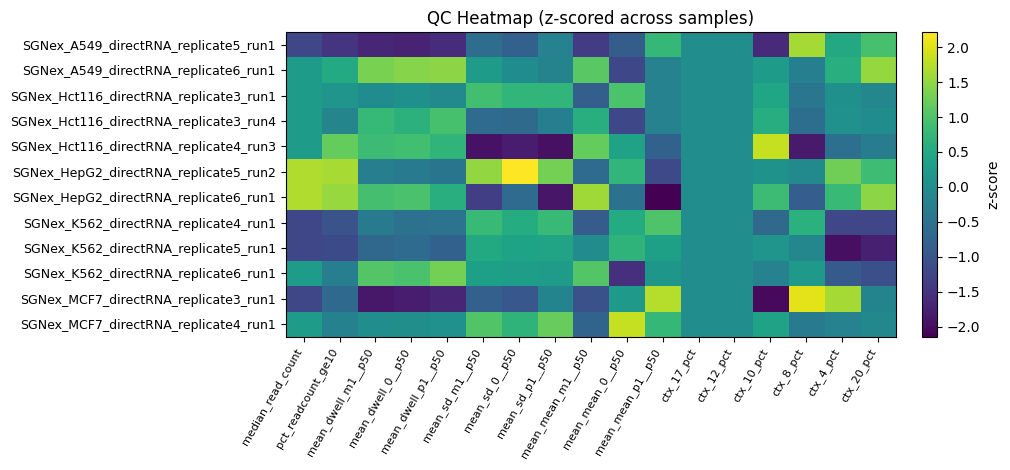

In [3]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PARQUET_DIR   = "data/processed_parquet"
PARQUET_GLOB  = "*.parquet"
OUTPUT_DIR    = "data/task2_outputs"

os.makedirs(OUTPUT_DIR, exist_ok=True)

FAMILY_COLS = {
    "dwell": ["mean_dwell_m1", "mean_dwell_0", "mean_dwell_p1"],
    "sd":    ["mean_sd_m1",    "mean_sd_0",    "mean_sd_p1"],
    "mean":  ["mean_mean_m1",  "mean_mean_0",  "mean_mean_p1"],
}
CTX_COLS = [f"ctx_{i}" for i in range(28)]

STATS = {
    "mean":  np.mean,
    "std":   np.std,
    "p10":   lambda x: np.nanpercentile(x, 10),
    "p50":   lambda x: np.nanpercentile(x, 50),
    "p90":   lambda x: np.nanpercentile(x, 90),
}

def summarize_series(arr: np.ndarray) -> dict:
    out = {}
    for name, fn in STATS.items():
        try:
            out[name] = float(fn(arr))
        except Exception:
            out[name] = np.nan
    return out

def process_one_parquet(fp: str) -> dict:
    """Read one parquet file, compute QC metrics for that sample only."""
    df = pd.read_parquet(fp)

    sample = str(df["sample"].iloc[0]) if "sample" in df.columns else os.path.basename(fp)
    cell_line = df["cell_line"].iloc[0] if "cell_line" in df.columns else None
    replicate = df["replicate"].iloc[0] if "replicate" in df.columns else None
    run = df["run"].iloc[0] if "run" in df.columns else None

    rec = {
        "sample": sample,
        "cell_line": cell_line,
        "replicate": replicate,
        "run": run,
        "n_sites": int(len(df)),
    }

    if "read_count" in df.columns:
        rc = pd.to_numeric(df["read_count"], errors="coerce")
        rec["median_read_count"] = float(rc.median())
        rec["pct_readcount_ge10"] = float((rc >= 10).mean() * 100.0)
    else:
        rec["median_read_count"] = np.nan
        rec["pct_readcount_ge10"] = np.nan

    for fam, cols in FAMILY_COLS.items():
        for c in cols:
            if c in df.columns:
                stats = summarize_series(pd.to_numeric(df[c], errors="coerce").values)
            else:
                stats = {k: np.nan for k in STATS.keys()}
            for stat_name, val in stats.items():
                rec[f"{c}__{stat_name}"] = val

    present_ctx = [c for c in CTX_COLS if c in df.columns]
    if present_ctx:
        ctx = df[present_ctx].apply(pd.to_numeric, errors="coerce").fillna(0)
        denom = max(len(ctx), 1)
        for c in present_ctx:
            rec[f"{c}_pct"] = float(ctx[c].sum() * 100.0 / denom)
    else:
        for c in CTX_COLS:
            rec[f"{c}_pct"] = np.nan

    return rec

def main():
    files = sorted(glob.glob(os.path.join(PARQUET_DIR, PARQUET_GLOB)))
    if not files:
        raise FileNotFoundError(f"No files matched: {os.path.join(PARQUET_DIR, PARQUET_GLOB)}")

    print(f"Found {len(files)} parquet files.")
    rows = []
    for fp in files:
        print(f"Processing: {fp}")
        rows.append(process_one_parquet(fp))

    qc = pd.DataFrame(rows)

    qc_csv = os.path.join(OUTPUT_DIR, "qc_summary.csv")
    qc.sort_values(["cell_line","replicate","run","sample"], na_position="last").to_csv(qc_csv, index=False)
    print(f"Wrote: {qc_csv}")

    heat_cols = [
        "median_read_count", "pct_readcount_ge10",
        "mean_dwell_m1__p50", "mean_dwell_0__p50", "mean_dwell_p1__p50",
        "mean_sd_m1__p50",    "mean_sd_0__p50",    "mean_sd_p1__p50",
        "mean_mean_m1__p50",  "mean_mean_0__p50",  "mean_mean_p1__p50",
    ]

    ctx_pct_cols = [c for c in qc.columns if c.endswith("_pct") and c.startswith("ctx_")]
    if ctx_pct_cols:
        ctx_means = qc[ctx_pct_cols].mean(numeric_only=True).sort_values(ascending=False)
        top_ctx = list(ctx_means.head(6).index)
        heat_cols.extend(top_ctx)

    heat_df = qc.set_index("sample")[heat_cols].copy()
    heat_df = heat_df.apply(pd.to_numeric, errors="coerce")
    z = (heat_df - heat_df.mean()) / (heat_df.std(ddof=0) + 1e-9)

    fig, ax = plt.subplots(figsize=(max(8, len(heat_cols)*0.6), max(4, len(z)*0.4)))
    im = ax.imshow(z.values, aspect="auto", interpolation="nearest")
    ax.set_xticks(range(len(heat_cols)))
    ax.set_xticklabels(heat_cols, rotation=60, ha="right", fontsize=8)
    ax.set_yticks(range(len(z.index)))
    ax.set_yticklabels(z.index, fontsize=9)
    ax.set_title("QC Heatmap (z-scored across samples)")
    cbar = plt.colorbar(im, ax=ax, fraction=0.025, pad=0.04)
    cbar.set_label("z-score")

    fig.tight_layout()
    fig_path = os.path.join(OUTPUT_DIR, "qc_heatmap.png")
    fig.savefig(fig_path, dpi=180)
    print(f"Wrote: {fig_path}")

if __name__ == "__main__":
    main()


Found 12 parquet files.
Reading: data/processed_parquet/SGNex_A549_directRNA_replicate5_run1_site_features.parquet
Reading: data/processed_parquet/SGNex_A549_directRNA_replicate6_run1_site_features.parquet
Reading: data/processed_parquet/SGNex_Hct116_directRNA_replicate3_run1_site_features.parquet
Reading: data/processed_parquet/SGNex_Hct116_directRNA_replicate3_run4_site_features.parquet
Reading: data/processed_parquet/SGNex_Hct116_directRNA_replicate4_run3_site_features.parquet
Reading: data/processed_parquet/SGNex_HepG2_directRNA_replicate5_run2_site_features.parquet
Reading: data/processed_parquet/SGNex_HepG2_directRNA_replicate6_run1_site_features.parquet
Reading: data/processed_parquet/SGNex_K562_directRNA_replicate4_run1_site_features.parquet
Reading: data/processed_parquet/SGNex_K562_directRNA_replicate5_run1_site_features.parquet
Reading: data/processed_parquet/SGNex_K562_directRNA_replicate6_run1_site_features.parquet
Reading: data/processed_parquet/SGNex_MCF7_directRNA_repli

/tmp/ipykernel_5002/679367376.py:182: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(


Wrote: data/task2_outputs/coverage_boxplot.png


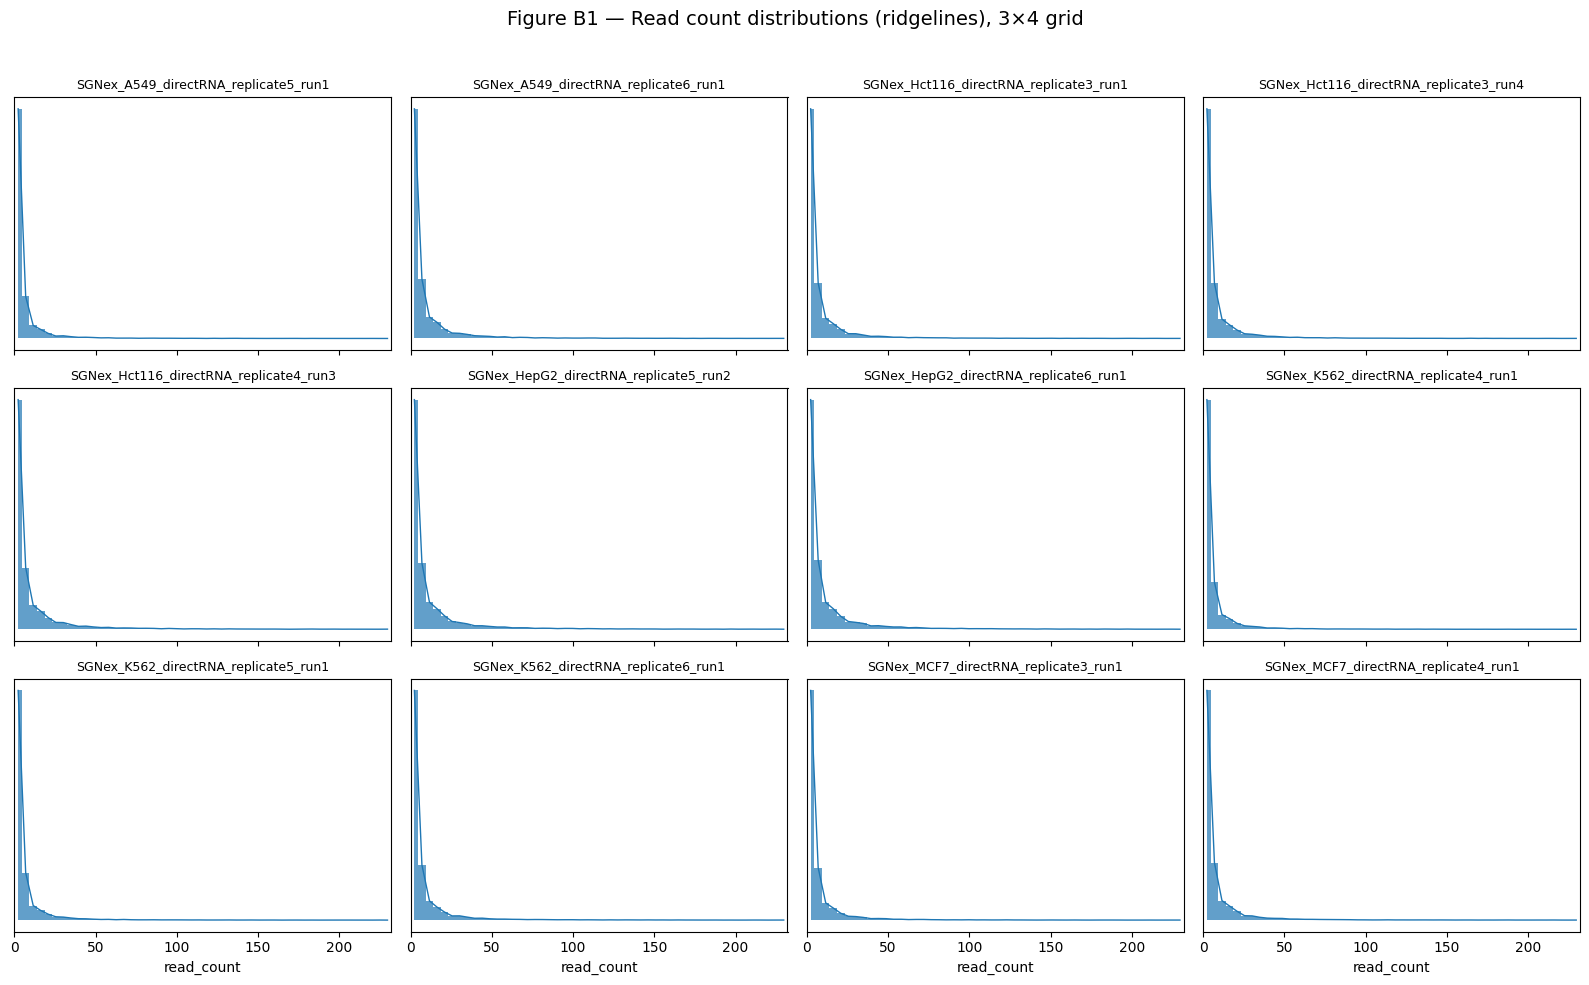

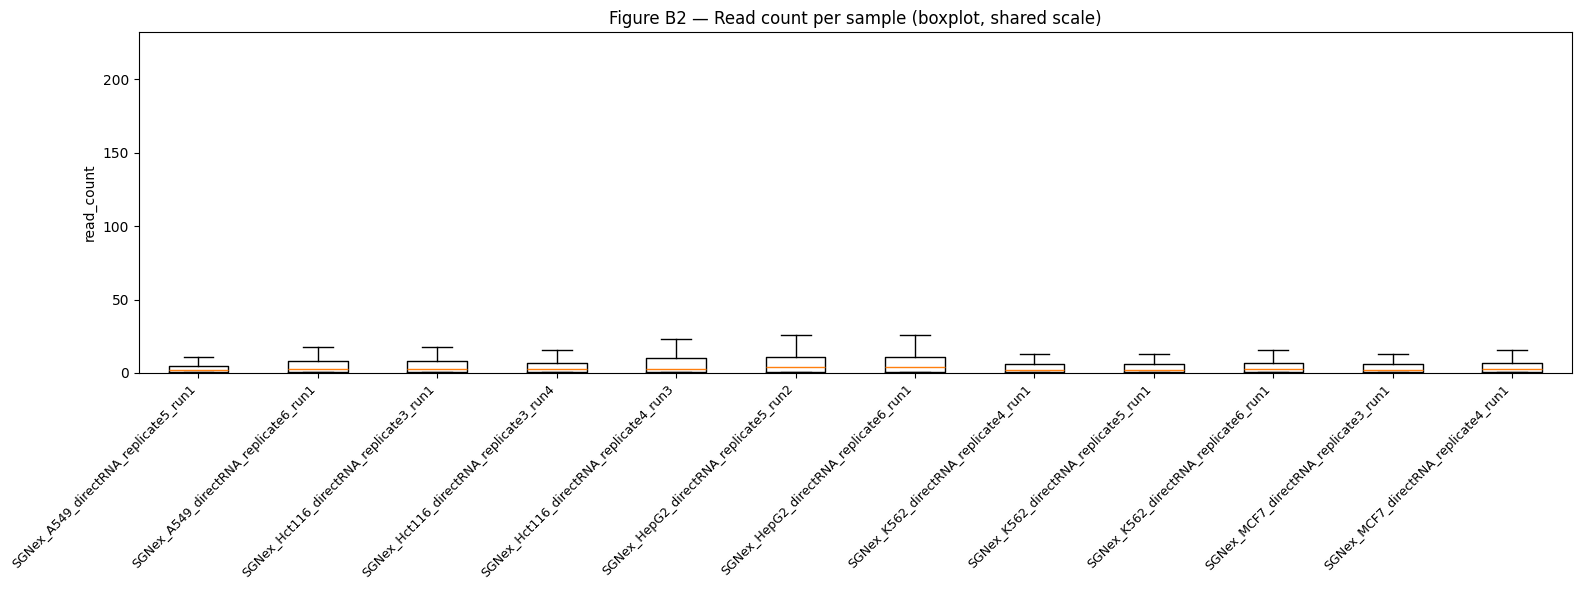

In [ ]:
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PARQUET_DIR   = "data/processed_parquet"
PARQUET_GLOB  = "*.parquet"
OUTPUT_DIR    = "data/task2_outputs"

THRESHOLDS = [10, 20]
MAX_POINTS_PER_SAMPLE = 50000
BINS = 50
CAP_PCT = 0.99
RNG = np.random.default_rng(42)

os.makedirs(OUTPUT_DIR, exist_ok=True)

SAMPLE_RE = re.compile(
    r"""^SGNex_
        (?P<cell_line>[A-Za-z0-9\-]+)
        _directRNA_
        replicate(?P<replicate>\d+)_
        run(?P<run>\d+)
        (?:_site_features)?$""", re.X
)

def parse_sample_from_name(path_or_name: str) -> str:
    base = os.path.splitext(os.path.basename(str(path_or_name)))[0]
    return base

def load_read_counts(parquet_path: str):
    want_cols = ["read_count", "sample"]
    df = pd.read_parquet(parquet_path, columns=None)
    cols = df.columns

    keep = ["read_count"] + (["sample"] if "sample" in cols else [])
    df = df[keep].copy()

    df["read_count"] = pd.to_numeric(df["read_count"], errors="coerce")

    if "sample" in df.columns:
        sample_label = str(df["sample"].dropna().iloc[0]) if len(df) else parse_sample_from_name(parquet_path)
    else:
        sample_label = parse_sample_from_name(parquet_path)
        df["sample"] = sample_label

    return df, sample_label

def summarize_counts(rc: pd.Series) -> dict:
    rc = pd.to_numeric(rc, errors="coerce")
    rc = rc[rc.notna()]
    if rc.empty:
        return {
            "n_sites": 0, "p25": np.nan, "p50": np.nan, "p75": np.nan,
            "mean": np.nan, "std": np.nan,
            **{f"pct_ge_{t}": np.nan for t in THRESHOLDS}
        }
    q25, q50, q75 = np.percentile(rc, [25, 50, 75])
    out = {
        "n_sites": int(rc.size),
        "p25": float(q25),
        "p50": float(q50),
        "p75": float(q75),
        "mean": float(rc.mean()),
        "std": float(rc.std(ddof=0)),
    }
    for t in THRESHOLDS:
        out[f"pct_ge_{t}"] = float((rc >= t).mean() * 100.0)
    return out

def downsample_for_plot(vec: np.ndarray, max_n: int) -> np.ndarray:
    n = vec.size
    if n <= max_n:
        return vec
    idx = RNG.choice(n, size=max_n, replace=False)
    return vec[idx]

def main():
    files = sorted(glob.glob(os.path.join(PARQUET_DIR, PARQUET_GLOB)))
    if not files:
        raise FileNotFoundError(f"No files matched: {os.path.join(PARQUET_DIR, PARQUET_GLOB)}")
    print(f"Found {len(files)} parquet files.")

    per_sample_stats = []
    plot_data = []

    max_for_cap = []
    for fp in files:
        print(f"Reading: {fp}")
        df, sample_label = load_read_counts(fp)

        stats = summarize_counts(df["read_count"])
        stats.update({"sample": sample_label})
        per_sample_stats.append(stats)

        rc = df["read_count"].to_numpy()
        rc = rc[np.isfinite(rc)]
        rc = rc[rc >= 0]
        rc_plot = downsample_for_plot(rc, MAX_POINTS_PER_SAMPLE)
        plot_data.append((sample_label, rc_plot))
        if rc_plot.size:
            max_for_cap.append(np.quantile(rc_plot, CAP_PCT))

    stats_df = pd.DataFrame(per_sample_stats)
    def sort_key(sname: str):
        base = os.path.splitext(os.path.basename(sname))[0]
        m = SAMPLE_RE.match(base)
        if m:
            return (m.group("cell_line"), int(m.group("replicate")), int(m.group("run")), base)
        return ("~", 9999, 9999, base)
    stats_df = stats_df.sort_values(key=lambda s: s.map(sort_key), by="sample")
    stats_csv = os.path.join(OUTPUT_DIR, "coverage_stats.csv")
    stats_df.to_csv(stats_csv, index=False)
    print(f"Wrote: {stats_csv}")

    if max_for_cap:
        x_max = float(max(max_for_cap))
    else:
        x_max = 1.0

    bins = np.linspace(0, x_max, BINS + 1)

    order = list(stats_df["sample"])
    ordered_plot = sorted(plot_data, key=lambda x: order.index(x[0]))

    n = len(ordered_plot)
    rows, cols = 3, 4
    fig, axes = plt.subplots(rows, cols, figsize=(16, 10), sharex=True)
    axes = axes.flatten()

    for i, (sample_label, rc_vec) in enumerate(ordered_plot):
        ax = axes[i]
        if rc_vec.size:
            hist, edges = np.histogram(rc_vec, bins=bins, density=True)
            mids = 0.5 * (edges[:-1] + edges[1:])
            ax.fill_between(mids, hist, step="mid", alpha=0.7)
            ax.plot(mids, hist, linewidth=1)
        ax.set_xlim(0, x_max)
        ax.set_yticks([])
        ax.set_title(sample_label, fontsize=9)
        if i // cols == rows - 1:
            ax.set_xlabel("read_count")
    for j in range(i + 1, rows * cols):
        axes[j].axis("off")

    fig.suptitle("Figure B1 — Read count distributions (ridgelines), 3×4 grid", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    out_ridge = os.path.join(OUTPUT_DIR, "coverage_ridgelines.png")
    fig.savefig(out_ridge, dpi=180)
    print(f"Wrote: {out_ridge}")

    data_for_box = [vec for (label, vec) in ordered_plot]
    labels = [label for (label, vec) in ordered_plot]

    fig2, ax2 = plt.subplots(figsize=(16, 6))
    ax2.boxplot(
        data_for_box,
        showfliers=False,
        labels=labels,
        vert=True
    )
    ax2.set_xlim(0.5, len(labels) + 0.5)
    ax2.set_ylim(0, x_max)
    ax2.set_ylabel("read_count")
    ax2.set_title("Figure B2 — Read count per sample (boxplot, shared scale)")
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", fontsize=9)

    fig2.tight_layout()
    out_box = os.path.join(OUTPUT_DIR, "coverage_boxplot.png")
    fig2.savefig(out_box, dpi=180)
    print(f"Wrote: {out_box}")

if __name__ == "__main__":
    main()


Summarizing: data/processed_parquet/SGNex_A549_directRNA_replicate5_run1_site_features.parquet
Summarizing: data/processed_parquet/SGNex_A549_directRNA_replicate6_run1_site_features.parquet
Summarizing: data/processed_parquet/SGNex_Hct116_directRNA_replicate3_run1_site_features.parquet
Summarizing: data/processed_parquet/SGNex_Hct116_directRNA_replicate3_run4_site_features.parquet
Summarizing: data/processed_parquet/SGNex_Hct116_directRNA_replicate4_run3_site_features.parquet
Summarizing: data/processed_parquet/SGNex_HepG2_directRNA_replicate5_run2_site_features.parquet
Summarizing: data/processed_parquet/SGNex_HepG2_directRNA_replicate6_run1_site_features.parquet
Summarizing: data/processed_parquet/SGNex_K562_directRNA_replicate4_run1_site_features.parquet
Summarizing: data/processed_parquet/SGNex_K562_directRNA_replicate5_run1_site_features.parquet
Summarizing: data/processed_parquet/SGNex_K562_directRNA_replicate6_run1_site_features.parquet
Summarizing: data/processed_parquet/SGNex_

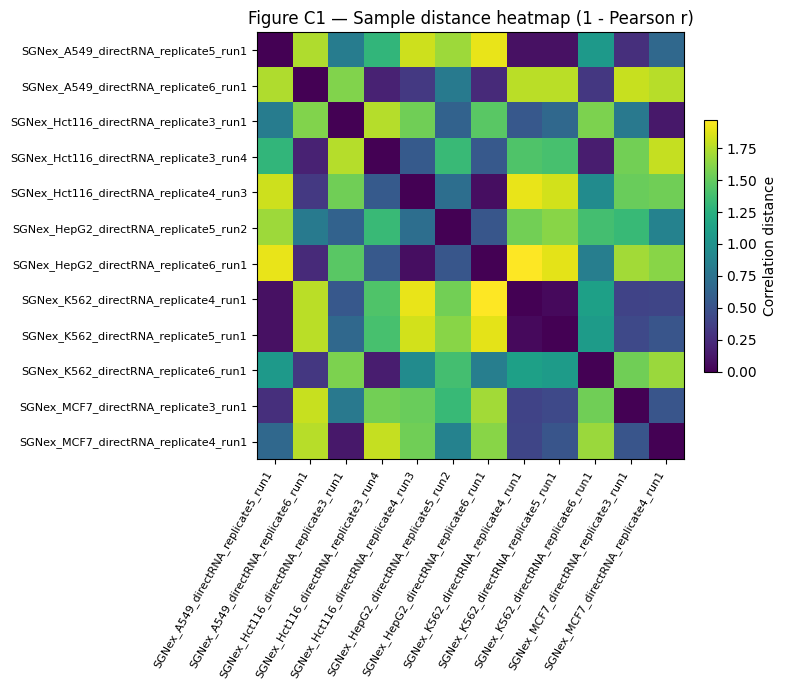

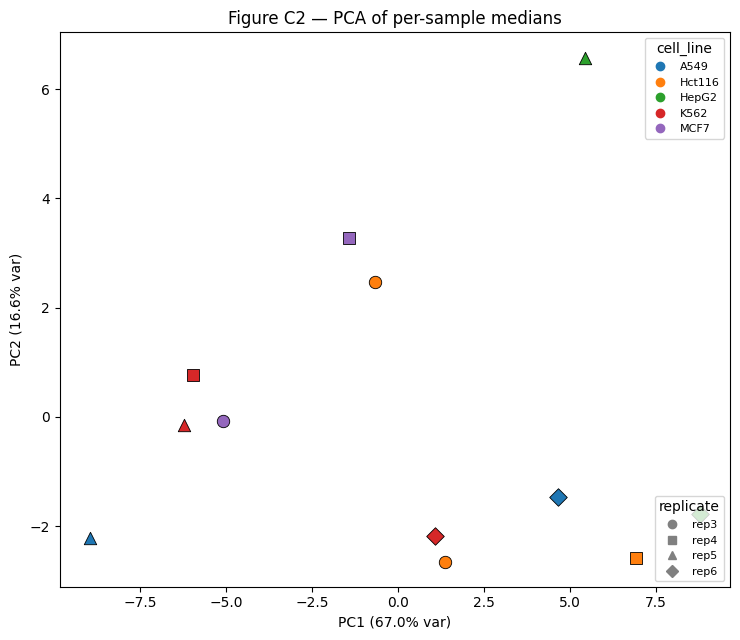

In [1]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastparquet import ParquetFile

PARQUET_DIR  = "data/processed_parquet"
PARQUET_GLOB = "*.parquet"
OUTPUT_DIR   = "data/task2_outputs"

os.makedirs(OUTPUT_DIR, exist_ok=True)

pos_tags    = ["m1", "0", "p1"]
feat_types  = ["dwell", "sd", "mean"]
stat_heads  = ["mean", "std", "min", "max", "median"]
STAT_COLS   = [f"{h}_{ft}_{pos}" for pos in pos_tags for ft in feat_types for h in stat_heads]
META_COLS   = ["sample", "cell_line", "replicate", "run"]

def read_sample_summary_fastparquet(path: str) -> dict:
    pf = ParquetFile(path)
    available = set(pf.columns)
    use_cols  = [c for c in STAT_COLS if c in available]
    meta_cols = [c for c in META_COLS   if c in available]

    df = pd.read_parquet(path, columns=use_cols + meta_cols, engine="fastparquet")

    base = os.path.splitext(os.path.basename(path))[0]
    sample    = str(df["sample"].iloc[0])  if "sample"    in df.columns else base
    cell_line = df["cell_line"].iloc[0]    if "cell_line" in df.columns else None
    replicate = df["replicate"].iloc[0]    if "replicate" in df.columns else None
    run       = df["run"].iloc[0]          if "run"       in df.columns else None

    rec = dict(sample=sample, cell_line=cell_line, replicate=replicate, run=run)
    for c in STAT_COLS:
        if c in df.columns:
            rec[c] = float(pd.to_numeric(df[c], errors="coerce").median())
        else:
            rec[c] = np.nan
    return rec

def zscore_cols(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for c in out.columns:
        x = out[c].to_numpy(dtype=float)
        mu = np.nanmean(x)
        sd = np.nanstd(x)
        out[c] = 0.0 if (not np.isfinite(sd) or sd == 0) else (x - mu) / sd
    return out

def corr_distance(M: np.ndarray) -> np.ndarray:
    n = M.shape[0]
    R = np.eye(n)
    for i in range(n):
        for j in range(i+1, n):
            xi, xj = M[i], M[j]
            mask = np.isfinite(xi) & np.isfinite(xj)
            if mask.sum() < 2:
                r = 0.0
            else:
                xi0 = xi[mask] - xi[mask].mean()
                xj0 = xj[mask] - xj[mask].mean()
                denom = np.sqrt((xi0**2).sum()) * np.sqrt((xj0**2).sum())
                r = float((xi0 @ xj0) / denom) if denom > 0 else 0.0
            R[i, j] = R[j, i] = r
    D = 1.0 - R
    np.fill_diagonal(D, 0.0)
    return D

def pca_2d(M: np.ndarray):
    Mc = M - np.nanmean(M, axis=0, keepdims=True)
    Mc = np.nan_to_num(Mc, nan=0.0)
    U, S, _ = np.linalg.svd(Mc, full_matrices=False)
    pcs = U[:, :2] * S[:2]
    var = S**2
    evr = var[:2] / var.sum() if var.sum() > 0 else np.array([0.0, 0.0])
    return pcs, evr

def main():
    files = sorted(glob.glob(os.path.join(PARQUET_DIR, PARQUET_GLOB)))
    if not files:
        raise FileNotFoundError(f"No files matched: {os.path.join(PARQUET_DIR, PARQUET_GLOB)}")

    rows = []
    for fp in files:
        print(f"Summarizing: {fp}")
        rows.append(read_sample_summary_fastparquet(fp))

    summary = pd.DataFrame(rows)

    out_summary_csv = os.path.join(OUTPUT_DIR, "sample_feature_summary.csv")
    summary.to_csv(out_summary_csv, index=False)
    print(f"Wrote: {out_summary_csv}")

    feat = summary[STAT_COLS]
    Z = zscore_cols(feat).to_numpy(dtype=float)
    D = corr_distance(Z)

    samples = summary["sample"].astype(str).tolist()
    dist_df = pd.DataFrame(D, index=samples, columns=samples)
    out_dist_csv = os.path.join(OUTPUT_DIR, "sample_distance_matrix.csv")
    dist_df.to_csv(out_dist_csv)
    print(f"Wrote: {out_dist_csv}")

    fig, ax = plt.subplots(figsize=(8, 7))
    im = ax.imshow(D, cmap="viridis", interpolation="nearest")
    ax.set_title("Figure C1 — Sample distance heatmap (1 - Pearson r)")
    ax.set_xticks(range(len(samples))); ax.set_yticks(range(len(samples)))
    ax.set_xticklabels(samples, rotation=60, ha="right", fontsize=8)
    ax.set_yticklabels(samples, fontsize=8)
    cbar = plt.colorbar(im, ax=ax, fraction=0.025, pad=0.04)
    cbar.set_label("Correlation distance")
    fig.tight_layout()
    heatmap_path = os.path.join(OUTPUT_DIR, "distance_heatmap.png")
    fig.savefig(heatmap_path, dpi=180)
    print(f"Wrote: {heatmap_path}")

    pcs, evr = pca_2d(Z)
    cell_lines = summary["cell_line"].astype(str).fillna("NA").tolist() if "cell_line" in summary else ["NA"]*len(samples)
    replicates = summary["replicate"].fillna(-1).astype(int).tolist()     if "replicate" in summary else [-1]*len(samples)

    unique_cl = sorted(set(cell_lines))
    cmap = plt.get_cmap("tab10")
    cl2color = {cl: cmap(i % 10) for i, cl in enumerate(unique_cl)}
    mkrs = ["o", "s", "^", "D", "P", "X", "v", "*"]
    reps_sorted = sorted(set(replicates))
    rep2mkr = {r: mkrs[i % len(mkrs)] for i, r in enumerate(reps_sorted)}

    fig2, ax2 = plt.subplots(figsize=(7.5, 6.5))
    for i, s in enumerate(samples):
        ax2.scatter(pcs[i,0], pcs[i,1],
                    color=cl2color[cell_lines[i]],
                    marker=rep2mkr[replicates[i]],
                    edgecolor="black", linewidths=0.6, s=80)
        ax2.text(pcs[i,0], pcs[i,1], f"", fontsize=8, va="center")
    ax2.set_xlabel(f"PC1 ({evr[0]*100:.1f}% var)"); ax2.set_ylabel(f"PC2 ({evr[1]*100:.1f}% var)")
    ax2.set_title("Figure C2 — PCA of per-sample medians")

    handles_cl = [plt.Line2D([0],[0], marker='o', color=cl2color[cl], label=cl, linestyle='') for cl in unique_cl]
    leg1 = ax2.legend(handles=handles_cl, title="cell_line", loc="upper right", fontsize=8)
    ax2.add_artist(leg1)
    handles_rp = [plt.Line2D([0],[0], marker=rep2mkr[r], color='gray', label=f"rep{r}", linestyle='') for r in reps_sorted]
    ax2.legend(handles=handles_rp, title="replicate", loc="lower right", fontsize=8)

    fig2.tight_layout()
    pca_path = os.path.join(OUTPUT_DIR, "pca_scatter.png")
    fig2.savefig(pca_path, dpi=180)
    print(f"Wrote: {pca_path}")

if __name__ == "__main__":
    main()

Reference mapping (sample -> ref_sample):
  SGNex_A549_directRNA_replicate5_run1  ->  SGNex_A549_directRNA_replicate5_run1
  SGNex_A549_directRNA_replicate6_run1  ->  SGNex_A549_directRNA_replicate5_run1
  SGNex_Hct116_directRNA_replicate3_run1  ->  SGNex_Hct116_directRNA_replicate3_run1
  SGNex_Hct116_directRNA_replicate3_run4  ->  SGNex_Hct116_directRNA_replicate3_run1
  SGNex_Hct116_directRNA_replicate4_run3  ->  SGNex_Hct116_directRNA_replicate3_run1
  SGNex_HepG2_directRNA_replicate5_run2  ->  SGNex_HepG2_directRNA_replicate5_run2
  SGNex_HepG2_directRNA_replicate6_run1  ->  SGNex_HepG2_directRNA_replicate5_run2
  SGNex_K562_directRNA_replicate4_run1  ->  SGNex_K562_directRNA_replicate4_run1
  SGNex_K562_directRNA_replicate5_run1  ->  SGNex_K562_directRNA_replicate4_run1
  SGNex_K562_directRNA_replicate6_run1  ->  SGNex_K562_directRNA_replicate4_run1
  SGNex_MCF7_directRNA_replicate3_run1  ->  SGNex_MCF7_directRNA_replicate3_run1
  SGNex_MCF7_directRNA_replicate4_run1  ->  SGNex_M

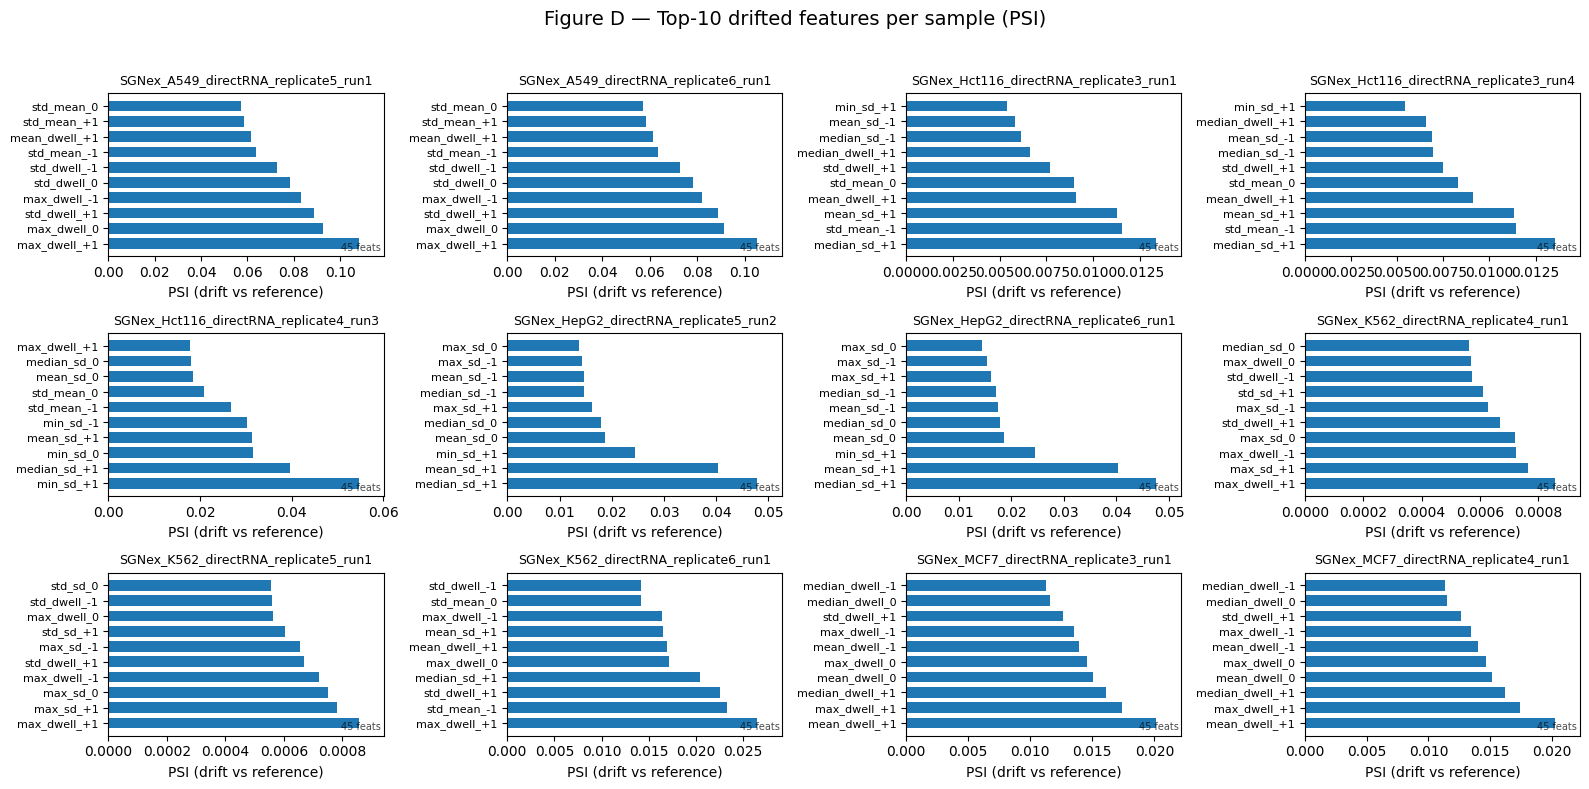

In [16]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastparquet import ParquetFile

PARQUET_DIR  = "data/processed_parquet"
PARQUET_GLOB = "*.parquet"
OUTPUT_DIR   = "data/task2_outputs"

REF_MODE = "per_cell_line_first"
REF_SAMPLE_OVERRIDE = None

PSI_BINS = 10
TOPK = 10
GRID = (3, 4)

os.makedirs(OUTPUT_DIR, exist_ok=True)

pos_tags   = ["m1", "0", "p1"]
feat_types = ["dwell", "sd", "mean"]
stats      = ["mean", "std", "min", "max", "median"]
STAT_COLS  = [f"{h}_{ft}_{pos}" for pos in pos_tags for ft in feat_types for h in stats]

META_COLS  = ["sample", "cell_line", "replicate", "run"]

def list_parquets():
    files = sorted(glob.glob(os.path.join(PARQUET_DIR, PARQUET_GLOB)))
    if not files:
        raise FileNotFoundError(f"No files matched: {os.path.join(PARQUET_DIR, PARQUET_GLOB)}")
    return files

def read_meta(path: str) -> dict:
    pf = ParquetFile(path)
    available = set(pf.columns)
    use_meta = [c for c in META_COLS if c in available]
    df = pd.read_parquet(path, columns=use_meta, engine="fastparquet")
    base = os.path.splitext(os.path.basename(path))[0]
    return {
        "path": path,
        "sample": str(df["sample"].iloc[0]) if "sample" in df.columns else base,
        "cell_line": df["cell_line"].iloc[0] if "cell_line" in df.columns else None,
        "replicate": int(df["replicate"].iloc[0]) if "replicate" in df.columns and pd.notna(df["replicate"].iloc[0]) else None,
        "run": int(df["run"].iloc[0]) if "run" in df.columns and pd.notna(df["run"].iloc[0]) else None,
    }

def read_features(path: str, cols: list) -> pd.DataFrame:
    """Read only the requested feature columns (skip missing, fill with NaN)."""
    pf = ParquetFile(path)
    available = set(pf.columns)
    use_cols = [c for c in cols if c in available]
    if not use_cols:
        return pd.DataFrame({c: pd.Series(dtype="float64") for c in cols})
    df = pd.read_parquet(path, columns=use_cols, engine="fastparquet")
    for c in cols:
        if c not in df.columns:
            df[c] = np.nan
    return df[cols]

def psi(ref_vals: np.ndarray, new_vals: np.ndarray, bins: int = PSI_BINS) -> float:
    ref = ref_vals[np.isfinite(ref_vals)]
    new = new_vals[np.isfinite(new_vals)]
    if ref.size < 5 or new.size < 5:
        return np.nan
    qs = np.linspace(0, 1, bins + 1)
    cuts = np.unique(np.quantile(ref, qs))
    if cuts.size <= 2:
        return np.nan
    h_ref, _ = np.histogram(ref, bins=cuts)
    h_new, _ = np.histogram(new, bins=cuts)

    p_ref = (h_ref + 1) / (h_ref.sum() + len(h_ref))
    p_new = (h_new + 1) / (h_new.sum() + len(h_new))
    val = float(np.sum((p_new - p_ref) * np.log(p_new / p_ref)))
    return max(val, 0.0)

def choose_references(meta_df: pd.DataFrame) -> dict:
    mapping = {}
    if REF_MODE == "single_sample":
        if not REF_SAMPLE_OVERRIDE:
            raise ValueError("REF_MODE='single_sample' but REF_SAMPLE_OVERRIDE is None.")
        for s in meta_df["sample"]:
            mapping[s] = REF_SAMPLE_OVERRIDE
        return mapping

    ref_per_cl = {}
    for cl, sub in meta_df.groupby("cell_line", dropna=False):
        def sort_key(row):
            rep = row["replicate"] if pd.notna(row["replicate"]) else 1_000_000
            run = row["run"] if pd.notna(row["run"]) else 1_000_000
            return (int(rep), int(run))
        sub_sorted = sorted(sub.to_dict("records"), key=sort_key)
        ref_per_cl[cl] = sub_sorted[0]["sample"]
    for _, row in meta_df.iterrows():
        mapping[row["sample"]] = ref_per_cl.get(row["cell_line"], row["sample"])
    return mapping

def alt_reference_for_self(meta_df: pd.DataFrame, sample: str) -> str:
    row = meta_df.loc[meta_df["sample"] == sample].iloc[0]
    cl = row["cell_line"]
    sub = (meta_df[meta_df["cell_line"] == cl]
           .sort_values(["replicate","run"], na_position="last"))
    if len(sub) >= 2:
        return sub["sample"].iloc[1]
    return sample

def main():
    files = list_parquets()
    metas = [read_meta(p) for p in files]
    meta_df = pd.DataFrame(metas).sort_values(by=["cell_line", "replicate", "run", "sample"], na_position="last")
    sample_to_path = {row["sample"]: row["path"] for _, row in meta_df.iterrows()}
    ref_map = choose_references(meta_df)

    print("Reference mapping (sample -> ref_sample):")
    for s in meta_df["sample"]:
        print(f"  {s}  ->  {ref_map[s]}")

    records = []
    cache = {}

    for _, row in meta_df.iterrows():
        s = row["sample"]
        s_path = row["path"]
        r_sample = ref_map[s]
        if s == r_sample:
            r_sample = alt_reference_for_self(meta_df, s)
        r_path = sample_to_path.get(r_sample)

        if r_path is None:
            print(f"[WARN] Reference sample '{r_sample}' missing for sample '{s}'. Skipping.")
            continue

        if r_path not in cache:
            cache[r_path] = read_features(r_path, STAT_COLS)
        if s_path not in cache:
            cache[s_path] = read_features(s_path, STAT_COLS)

        df_ref = cache[r_path]
        df_new = cache[s_path]

        for feat in STAT_COLS:
            ref_vals = pd.to_numeric(df_ref[feat], errors="coerce").to_numpy()
            new_vals = pd.to_numeric(df_new[feat], errors="coerce").to_numpy()
            val = psi(ref_vals, new_vals, bins=PSI_BINS)
            records.append({"sample": s, "feature": feat, "psi": val, "ref_sample": r_sample})

    drift_df = pd.DataFrame(records)
    if drift_df.empty:
        raise RuntimeError("No drift results computed. Do your Parquet files contain the STAT_COLS?")

    drift_df["rank"] = drift_df.groupby("sample")["psi"].rank(
        method="first", ascending=False, na_option="bottom"
    ).astype("Int64")

    out_csv = os.path.join(OUTPUT_DIR, "drift_per_feature.csv")
    drift_df.sort_values(["sample", "rank", "feature"]).to_csv(out_csv, index=False)
    print(f"Wrote: {out_csv}")

    samples = meta_df["sample"].tolist()
    rows, cols = GRID
    n = len(samples)
    rows = max(rows, int(np.ceil(n / cols)))
    fig, axes = plt.subplots(rows, cols, figsize=(16, max(8, rows * 2.6)))
    axes = axes.flatten()

    for i, s in enumerate(samples):
        ax = axes[i]
        sub = drift_df[drift_df["sample"] == s].dropna(subset=["psi"])

        topk = sub.sort_values("psi", ascending=False).head(TOPK)
        if topk.empty:
            ax.axis("off")
            ax.set_title(f"{s}\n(no drift / insufficient data)", fontsize=9)
            continue

        labels = (topk["feature"]
                  .str.replace("_m1$", "_-1", regex=True)
                  .str.replace("_p1$", "_+1", regex=True))
        y = np.arange(len(topk))[::-1]
        ax.barh(y, topk["psi"].values, height=0.7)
        ax.set_yticks(y)
        ax.set_yticklabels(labels, fontsize=8)
        ax.invert_yaxis()
        ax.set_xlabel("PSI (drift vs reference)")
        ax.set_xlim(0, float(topk["psi"].max()) * 1.1)
        ax.set_title(s, fontsize=9)
        ax.text(0.99, 0.02, f"{sub['psi'].notna().sum()} feats", transform=ax.transAxes,
                ha="right", va="bottom", fontsize=7, alpha=0.7)

    for j in range(i + 1, rows * cols):
        axes[j].axis("off")

    fig.suptitle("Figure D — Top-10 drifted features per sample (PSI)", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    fig_path = os.path.join(OUTPUT_DIR, "drift_top10_grid.png")
    fig.savefig(fig_path, dpi=180)
    print(f"Wrote: {fig_path}")

if __name__ == "__main__":
    main()

Summarizing: data/processed_parquet/SGNex_A549_directRNA_replicate5_run1_site_features.parquet
Summarizing: data/processed_parquet/SGNex_A549_directRNA_replicate6_run1_site_features.parquet
Summarizing: data/processed_parquet/SGNex_Hct116_directRNA_replicate3_run1_site_features.parquet
Summarizing: data/processed_parquet/SGNex_Hct116_directRNA_replicate3_run4_site_features.parquet
Summarizing: data/processed_parquet/SGNex_Hct116_directRNA_replicate4_run3_site_features.parquet
Summarizing: data/processed_parquet/SGNex_HepG2_directRNA_replicate5_run2_site_features.parquet
Summarizing: data/processed_parquet/SGNex_HepG2_directRNA_replicate6_run1_site_features.parquet
Summarizing: data/processed_parquet/SGNex_K562_directRNA_replicate4_run1_site_features.parquet
Summarizing: data/processed_parquet/SGNex_K562_directRNA_replicate5_run1_site_features.parquet
Summarizing: data/processed_parquet/SGNex_K562_directRNA_replicate6_run1_site_features.parquet
Summarizing: data/processed_parquet/SGNex_

/tmp/ipykernel_5002/1777295972.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Wrote: data/task2_outputs/context_heatmap.png


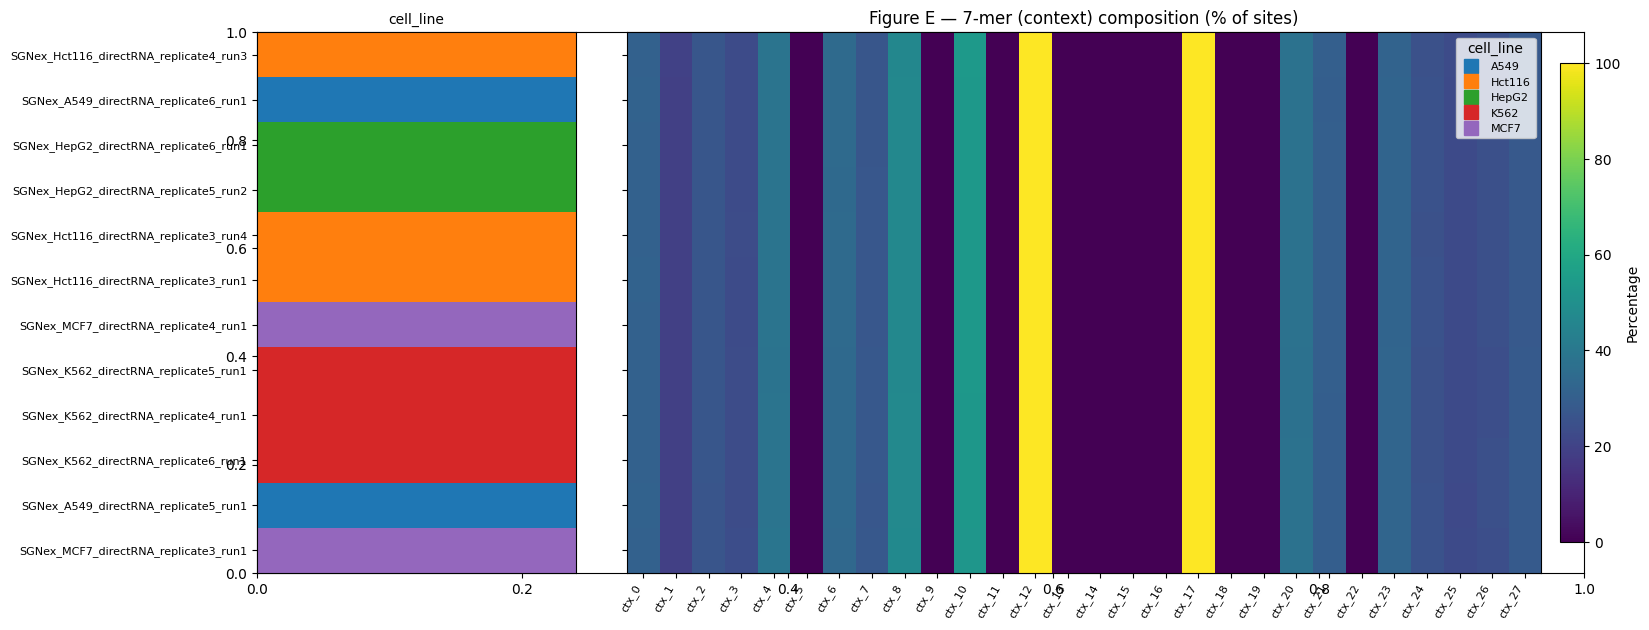

In [ ]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastparquet import ParquetFile

PARQUET_DIR  = "data/processed_parquet"
PARQUET_GLOB = "*.parquet"
OUTPUT_DIR   = "data/task2_outputs"

os.makedirs(OUTPUT_DIR, exist_ok=True)

CTX_COLS = [f"ctx_{i}" for i in range(28)]
META_COLS = ["sample", "cell_line"]

def read_ctx_composition(path: str) -> dict:
    pf = ParquetFile(path)
    available = set(pf.columns)
    use_ctx = [c for c in CTX_COLS if c in available]
    use_meta = [c for c in META_COLS if c in available]

    df = pd.read_parquet(path, columns=use_ctx + use_meta, engine="fastparquet")

    base = os.path.splitext(os.path.basename(path))[0]
    sample = str(df["sample"].iloc[0]) if "sample" in df.columns else base
    cell_line = df["cell_line"].iloc[0] if "cell_line" in df.columns else None

    for c in CTX_COLS:
        if c not in df.columns:
            df[c] = 0

    ctx = df[CTX_COLS].apply(pd.to_numeric, errors="coerce").fillna(0)
    n = max(len(ctx), 1)
    pct = (ctx.sum(axis=0) * 100.0 / n).to_dict()

    rec = {"sample": sample, "cell_line": cell_line}
    rec.update(pct)
    return rec

def try_cluster_order(matrix: np.ndarray, labels: list):
    try:
        from scipy.spatial.distance import pdist
        from scipy.cluster.hierarchy import linkage, dendrogram

        D = pdist(matrix, metric="correlation")
        Z = linkage(D, method="average")
        order = dendrogram(Z, no_plot=True, labels=np.arange(len(labels)))["leaves"]
        return order
    except Exception:

        return list(range(len(labels)))

def main():
    files = sorted(glob.glob(os.path.join(PARQUET_DIR, PARQUET_GLOB)))
    if not files:
        raise FileNotFoundError(f"No files matched: {os.path.join(PARQUET_DIR, PARQUET_GLOB)}")

    rows = []
    for fp in files:
        print(f"Summarizing: {fp}")
        rows.append(read_ctx_composition(fp))

    comp = pd.DataFrame(rows)
    comp = comp[["sample", "cell_line"] + CTX_COLS]

    out_csv = os.path.join(OUTPUT_DIR, "context_composition.csv")
    comp.to_csv(out_csv, index=False)
    print(f"Wrote: {out_csv}")

    samples = comp["sample"].astype(str).tolist()
    cell_lines = comp["cell_line"].astype(str).fillna("NA").tolist()
    X = comp[CTX_COLS].to_numpy(dtype=float)

    row_order = try_cluster_order(X, samples)
    X_ord = X[row_order, :]
    samples_ord = [samples[i] for i in row_order]
    cls_ord = [cell_lines[i] for i in row_order]

    uniq_cl = sorted(set(cls_ord))
    cmap = plt.get_cmap("tab10")
    cl2color = {cl: cmap(i % 10) for i, cl in enumerate(uniq_cl)}
    row_colors = [cl2color[cl] for cl in cls_ord]

    fig = plt.subplots(figsize=(14, max(6, 0.45 * len(samples_ord))))[0]
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[0.25, 0.75], wspace=0.08)

    ax_strip = fig.add_subplot(gs[0, 0])
    ax_strip.imshow(np.array(row_colors).reshape(-1, 1, 4), aspect="auto")
    ax_strip.set_yticks(range(len(samples_ord)))
    ax_strip.set_yticklabels(samples_ord, fontsize=8)
    ax_strip.set_xticks([])
    ax_strip.set_title("cell_line", fontsize=10)

    ax = fig.add_subplot(gs[0, 1])
    im = ax.imshow(X_ord, aspect="auto", interpolation="nearest")
    ax.set_yticks(range(len(samples_ord)))
    ax.set_yticklabels([])
    ax.set_xticks(range(len(CTX_COLS)))
    ax.set_xticklabels(CTX_COLS, rotation=60, ha="right", fontsize=8)
    ax.set_title("Figure E — 7-mer (context) composition (% of sites)")

    cbar = plt.colorbar(im, ax=ax, fraction=0.025, pad=0.02)
    cbar.set_label("Percentage")

    handles = [plt.Line2D([0],[0], marker='s', color=cl2color[cl], label=cl, linestyle='', markersize=10)
               for cl in uniq_cl]
    ax.legend(handles=handles, title="cell_line", loc="upper right", fontsize=8)

    fig.tight_layout()
    fig_path = os.path.join(OUTPUT_DIR, "context_heatmap.png")
    fig.savefig(fig_path, dpi=180)
    print(f"Wrote: {fig_path}")

if __name__ == "__main__":
    main()


Summarizing: data/processed_parquet/SGNex_A549_directRNA_replicate5_run1_site_features.parquet
Summarizing: data/processed_parquet/SGNex_A549_directRNA_replicate6_run1_site_features.parquet
Summarizing: data/processed_parquet/SGNex_Hct116_directRNA_replicate3_run1_site_features.parquet
Summarizing: data/processed_parquet/SGNex_Hct116_directRNA_replicate3_run4_site_features.parquet
Summarizing: data/processed_parquet/SGNex_Hct116_directRNA_replicate4_run3_site_features.parquet
Summarizing: data/processed_parquet/SGNex_HepG2_directRNA_replicate5_run2_site_features.parquet
Summarizing: data/processed_parquet/SGNex_HepG2_directRNA_replicate6_run1_site_features.parquet
Summarizing: data/processed_parquet/SGNex_K562_directRNA_replicate4_run1_site_features.parquet
Summarizing: data/processed_parquet/SGNex_K562_directRNA_replicate5_run1_site_features.parquet
Summarizing: data/processed_parquet/SGNex_K562_directRNA_replicate6_run1_site_features.parquet
Summarizing: data/processed_parquet/SGNex_

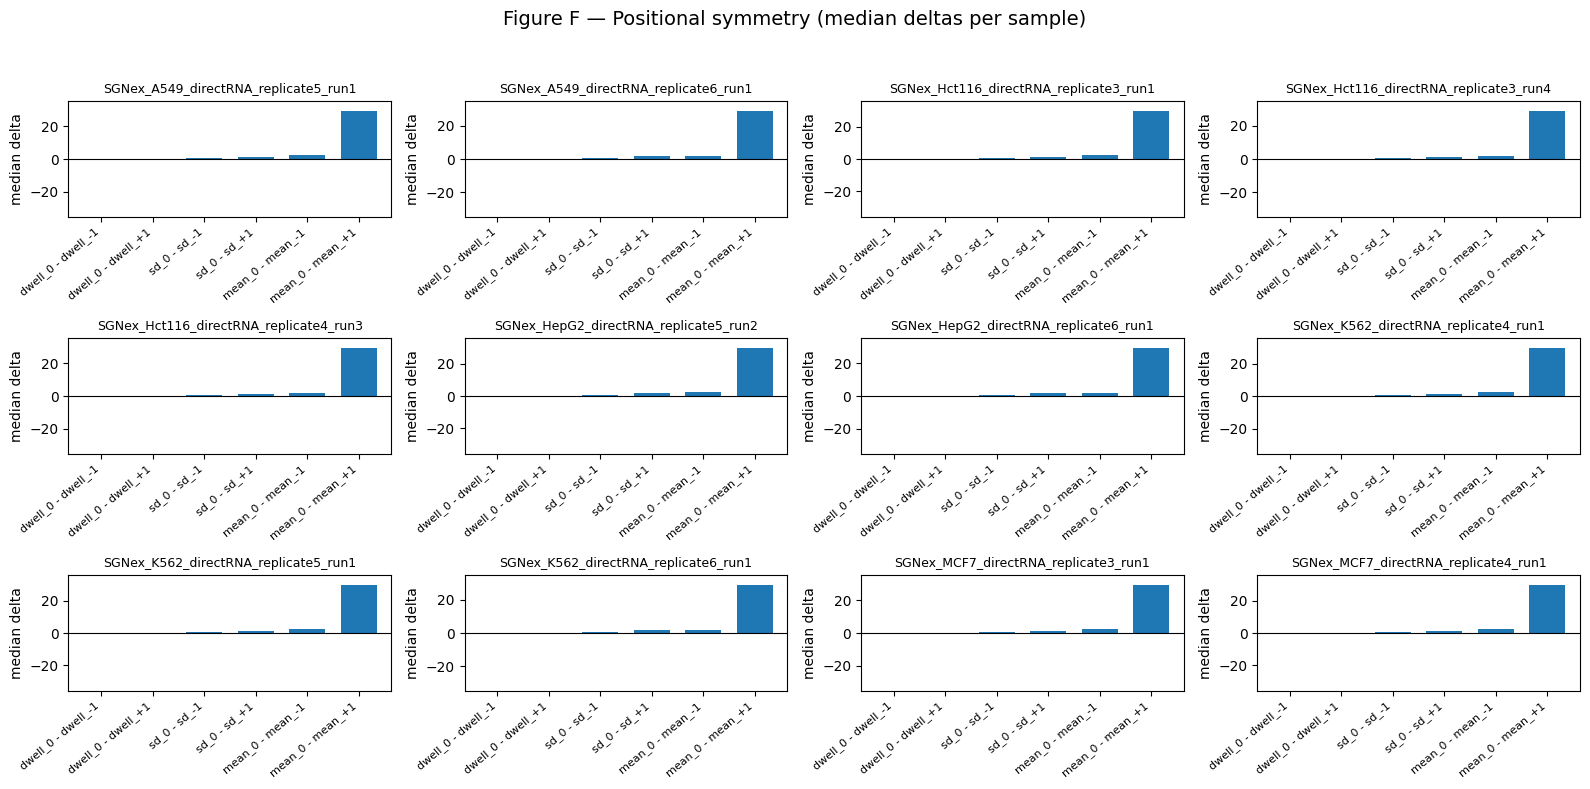

In [ ]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastparquet import ParquetFile

PARQUET_DIR  = "data/processed_parquet"
PARQUET_GLOB = "*.parquet"
OUTPUT_DIR   = "data/task2_outputs"

os.makedirs(OUTPUT_DIR, exist_ok=True)

FAMS = ["dwell", "sd", "mean"]
COLS_NEEDED = {
    "dwell": ["mean_dwell_m1", "mean_dwell_0", "mean_dwell_p1"],
    "sd":    ["mean_sd_m1",    "mean_sd_0",    "mean_sd_p1"],
    "mean":  ["mean_mean_m1",  "mean_mean_0",  "mean_mean_p1"],
}
META_COLS = ["sample", "cell_line", "replicate", "run"]

def read_needed(path: str):
    pf = ParquetFile(path)
    available = set(pf.columns)
    want = set(META_COLS)
    for fam in FAMS:
        want.update(COLS_NEEDED[fam])

    use_cols = [c for c in want if c in available]
    df = pd.read_parquet(path, columns=use_cols, engine="fastparquet")

    for fam in FAMS:
        for c in COLS_NEEDED[fam]:
            if c not in df.columns:
                df[c] = np.nan

    base = os.path.splitext(os.path.basename(path))[0]
    df["sample"] = df["sample"] if "sample" in df.columns else base
    df["cell_line"] = df["cell_line"] if "cell_line" in df.columns else None
    df["replicate"] = df["replicate"] if "replicate" in df.columns else None
    df["run"] = df["run"] if "run" in df.columns else None

    return df

def median_delta(a: pd.Series, b: pd.Series) -> float:
    x = pd.to_numeric(a, errors="coerce") - pd.to_numeric(b, errors="coerce")
    return float(x.median(skipna=True))

def process_file(path: str) -> dict:
    df = read_needed(path)
    first = df.iloc[0]
    rec = {
        "sample": str(first["sample"]),
        "cell_line": first["cell_line"],
        "replicate": first["replicate"],
        "run": first["run"],
        "n_sites": int(len(df)),
    }

    for fam in FAMS:
        m1, p0, p1 = COLS_NEEDED[fam]
        rec[f"{fam}_d0_m1_med"] = median_delta(df[p0], df[m1])
        rec[f"{fam}_d0_p1_med"] = median_delta(df[p0], df[p1])

    return rec

def main():
    files = sorted(glob.glob(os.path.join(PARQUET_DIR, PARQUET_GLOB)))
    if not files:
        raise FileNotFoundError(f"No files matched: {os.path.join(PARQUET_DIR, PARQUET_GLOB)}")

    rows = []
    for fp in files:
        print(f"Summarizing: {fp}")
        rows.append(process_file(fp))

    summ = pd.DataFrame(rows)
    summ = summ.sort_values(by=["cell_line", "replicate", "run", "sample"], na_position="last").reset_index(drop=True)

    out_csv = os.path.join(OUTPUT_DIR, "pos_symmetry_summary.csv")
    summ.to_csv(out_csv, index=False)
    print(f"Wrote: {out_csv}")

    samples = summ["sample"].astype(str).tolist()
    metrics = [
        ("dwell_0 - dwell_-1", "dwell_d0_m1_med"),
        ("dwell_0 - dwell_+1", "dwell_d0_p1_med"),
        ("sd_0 - sd_-1",       "sd_d0_m1_med"),
        ("sd_0 - sd_+1",       "sd_d0_p1_med"),
        ("mean_0 - mean_-1",   "mean_d0_m1_med"),
        ("mean_0 - mean_+1",   "mean_d0_p1_med"),
    ]

    rows_grid, cols_grid = 3, 4
    n = len(samples)
    rows_grid = max(rows_grid, int(np.ceil(n / cols_grid)))

    fig, axes = plt.subplots(rows_grid, cols_grid, figsize=(16, max(8, rows_grid * 2.6)))
    axes = axes.flatten()

    for i, s in enumerate(samples):
        ax = axes[i]
        row = summ.loc[summ["sample"] == s].iloc[0]
        vals = [float(row[m]) if pd.notna(row[m]) else np.nan for _, m in metrics]
        labels = [lab for lab, _ in metrics]

        x = np.arange(len(labels))
        ax.bar(x, vals, width=0.7)

        ax.axhline(0, color="black", linewidth=0.8)

        finite = np.array([v for v in vals if np.isfinite(v)])
        if finite.size:
            ymax = float(np.max(np.abs(finite))) * 1.2
            if ymax == 0:
                ymax = 1e-6
        else:
            ymax = 1e-6
        ax.set_ylim(-ymax, ymax)

        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=40, ha="right", fontsize=8)
        ax.set_ylabel("median delta")
        ax.set_title(s, fontsize=9)

    for j in range(i + 1, rows_grid * cols_grid):
        axes[j].axis("off")

    fig.suptitle("Figure F — Positional symmetry (median deltas per sample)", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    out_fig = os.path.join(OUTPUT_DIR, "pos_symmetry_grid.png")
    fig.savefig(out_fig, dpi=180)
    print(f"Wrote: {out_fig}")

if __name__ == "__main__":
    main()


describe the results

Reading: results/SGNex_A549_directRNA_replicate5_run1_site_features_scores.csv
Reading: results/SGNex_A549_directRNA_replicate6_run1_site_features_scores.csv
Reading: results/SGNex_Hct116_directRNA_replicate3_run1_site_features_scores.csv
Reading: results/SGNex_Hct116_directRNA_replicate3_run4_site_features_scores.csv
Reading: results/SGNex_Hct116_directRNA_replicate4_run3_site_features_scores.csv
Reading: results/SGNex_HepG2_directRNA_replicate5_run2_site_features_scores.csv
Reading: results/SGNex_HepG2_directRNA_replicate6_run1_site_features_scores.csv
Reading: results/SGNex_K562_directRNA_replicate4_run1_site_features_scores.csv
Reading: results/SGNex_K562_directRNA_replicate5_run1_site_features_scores.csv
Reading: results/SGNex_K562_directRNA_replicate6_run1_site_features_scores.csv
Reading: results/SGNex_MCF7_directRNA_replicate3_run1_site_features_scores.csv
Reading: results/SGNex_MCF7_directRNA_replicate4_run1_site_features_scores.csv
Wrote: data/task2_outputs2/scores_summary.cs

/tmp/ipykernel_5002/1320778285.py:229: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels, rotation=60, ha="right", fontsize=8)


Wrote: data/task2_outputs2/call_counts.png
Wrote: data/task2_outputs2/consensus_A549.csv
Wrote: data/task2_outputs2/consensus_Hct116.csv
Wrote: data/task2_outputs2/consensus_HepG2.csv
Wrote: data/task2_outputs2/consensus_K562.csv
Wrote: data/task2_outputs2/consensus_MCF7.csv


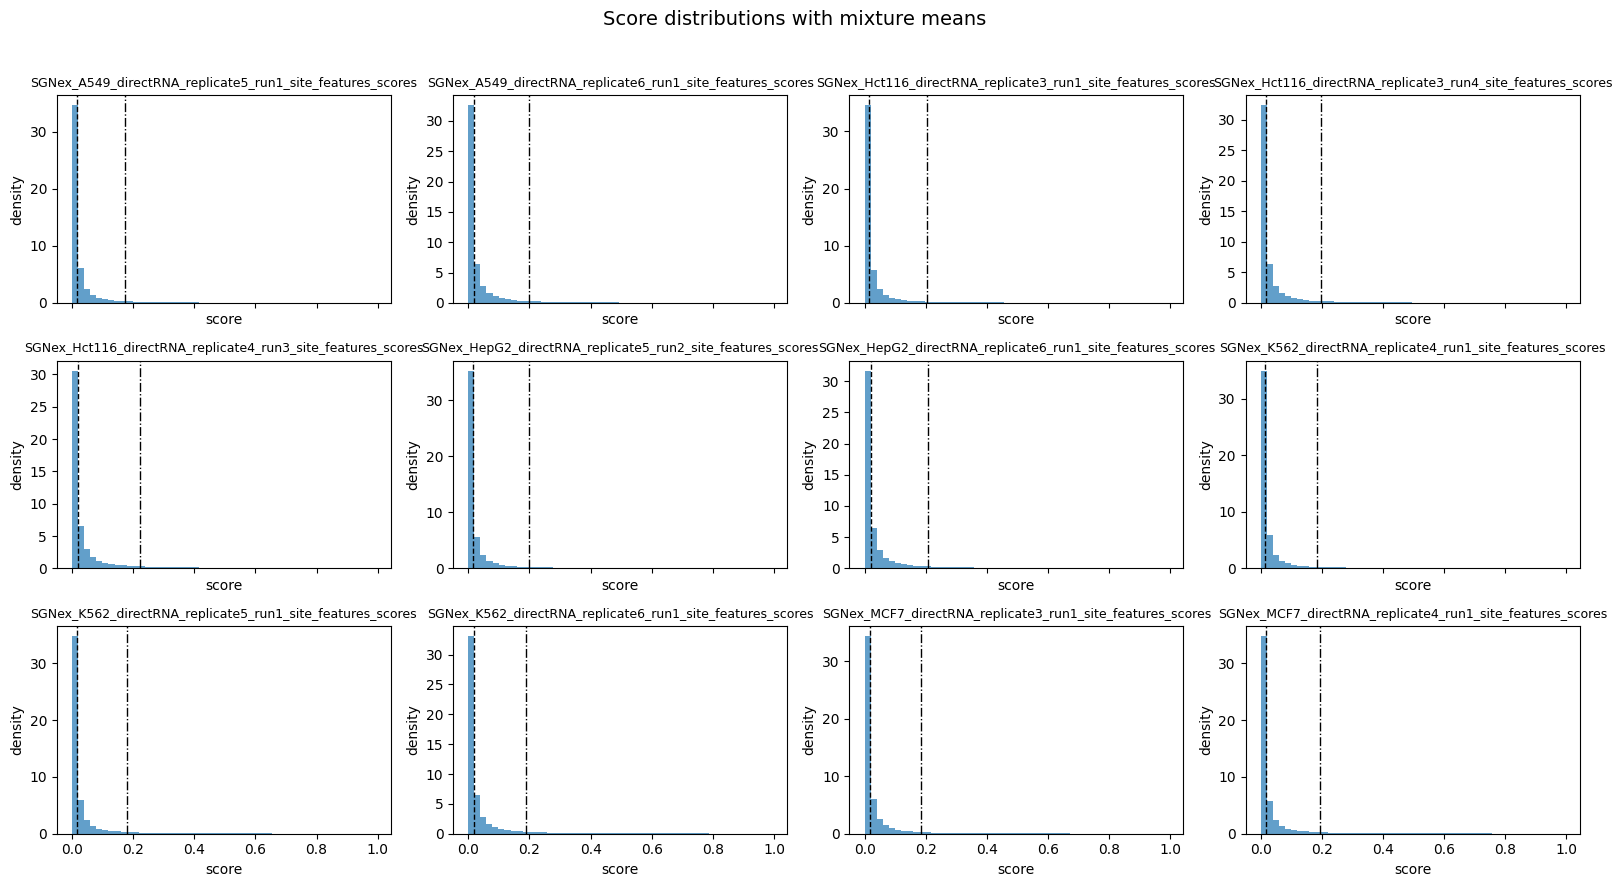

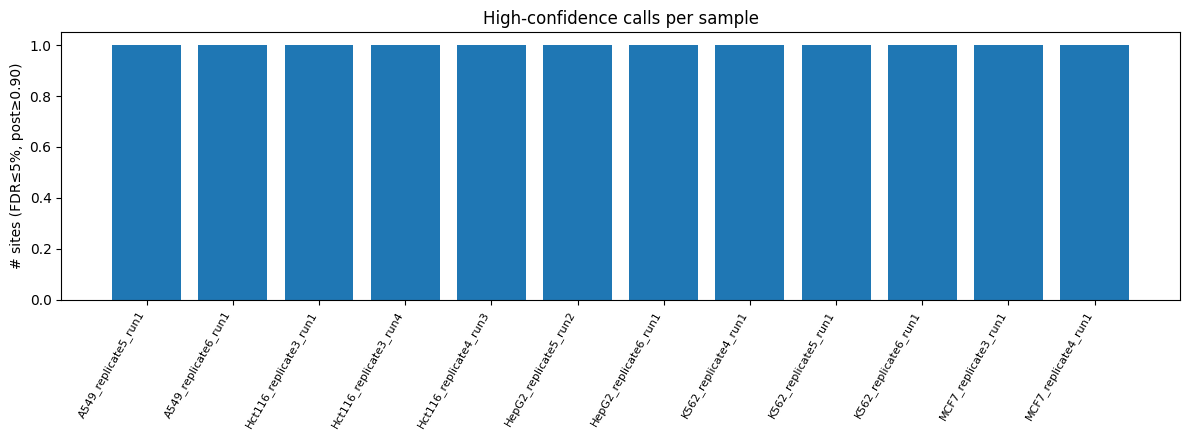

In [25]:
import os, re, glob, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SCORES_DIR   = "results"
FILE_GLOB    = "*_scores.csv"
OUTPUT_DIR   = "data/task2_outputs2"
TARGET_FDR   = 0.05
POST_CUTOFF  = 0.90
MAX_PLOT_N   = 2_000_000

os.makedirs(OUTPUT_DIR, exist_ok=True)

SAMPLE_RE = re.compile(
    r"""^SGNex_
        (?P<cell_line>[A-Za-z0-9\-]+)
        _directRNA_
        replicate(?P<replicate>\d+)_
        run(?P<run>\d+)_
        site_features_scores$""", re.X
)

def parse_from_filename(path):
    base = os.path.splitext(os.path.basename(path))[0]
    m = SAMPLE_RE.match(base)
    meta = {"sample": base, "cell_line": None, "replicate": None, "run": None}
    if m:
        meta.update({
            "cell_line": m.group("cell_line"),
            "replicate": int(m.group("replicate")),
            "run": int(m.group("run")),
        })
    return meta

def read_scores_csv(path):
    usecols = ["transcript_id", "transcript_position", "score"]
    dtypes = {"transcript_id": "string", "transcript_position": "int64", "score": "float64"}
    df = pd.read_csv(path, usecols=usecols, dtype=dtypes)
    return df

def _beta_moments_to_ab(mean, var, eps=1e-8):
    var = max(var, eps)
    m = min(max(mean, eps), 1 - eps)
    k = m*(1 - m)/var - 1.0
    a = m * k
    b = (1 - m) * k
    if not np.isfinite(a) or not np.isfinite(b) or a <= 0 or b <= 0:
        a, b = 2.0, 2.0
    return float(a), float(b)

def fit_beta_mixture(scores, max_iter=200, tol=1e-6):
    x = scores[np.isfinite(scores)]
    x = x[(x > 0) & (x < 1)]
    if x.size < 100:
        return {"pi": [0.5, 0.5], "ab": [(2.0, 5.0), (5.0, 2.0)]}

    m = np.median(x)
    w0, w1 = 0.6, 0.4
    a0, b0 = _beta_moments_to_ab(mean=min(m, 0.4), var=np.var(x[x <= m]) + 1e-4)
    a1, b1 = _beta_moments_to_ab(mean=max(m, 0.6), var=np.var(x[x >= m]) + 1e-4)

    def log_beta_pdf(xx, a, b):
        from math import lgamma
        return (a - 1.0) * np.log(xx) + (b - 1.0) * np.log1p(-xx) - (lgamma(a) + lgamma(b) - lgamma(a + b))

    for it in range(max_iter):
        logp0 = np.log(w0 + 1e-12) + log_beta_pdf(x, a0, b0)
        logp1 = np.log(w1 + 1e-12) + log_beta_pdf(x, a1, b1)
        mmax = np.maximum(logp0, logp1)
        p0 = np.exp(logp0 - mmax); p1 = np.exp(logp1 - mmax)
        gamma1 = p1 / (p0 + p1 + 1e-12)
        gamma0 = 1.0 - gamma1

        w0_new = float(gamma0.mean()); w1_new = 1.0 - w0_new

        def wstats(g):
            gsum = g.sum() + 1e-12
            mu = float((g * x).sum() / gsum)
            v = float((g * (x - mu)**2).sum() / gsum)
            return mu, v
        mu0, var0 = wstats(gamma0)
        mu1, var1 = wstats(gamma1)

        a0_new, b0_new = _beta_moments_to_ab(mu0, var0)
        a1_new, b1_new = _beta_moments_to_ab(mu1, var1)

        delta = max(abs(w0_new - w0), abs(a0_new - a0) + abs(b0_new - b0),
                    abs(a1_new - a1) + abs(b1_new - b1))
        w0, w1 = w0_new, w1_new
        a0, b0 = a0_new, b0_new
        a1, b1 = a1_new, b1_new
        if delta < tol:
            break

    mean0 = a0 / (a0 + b0)
    mean1 = a1 / (a1 + b1)
    if mean0 > mean1:
        a0, b0, a1, b1 = a1, b1, a0, b0
        w0, w1 = w1, w0
    return {"pi": [w0, w1], "ab": [(a0, b0), (a1, b1)]}

def posterior_modified(scores, mix):
    from math import lgamma
    x = scores
    a0, b0 = mix["ab"][0]; a1, b1 = mix["ab"][1]
    w0, w1 = mix["pi"]
    def lpdf(xx, a, b):
        return (a - 1.0) * np.log(xx + 1e-12) + (b - 1.0) * np.log1p(-xx + 1e-12) - (lgamma(a) + lgamma(b) - lgamma(a + b))
    l0 = np.log(w0 + 1e-12) + lpdf(x, a0, b0)
    l1 = np.log(w1 + 1e-12) + lpdf(x, a1, b1)
    m = np.maximum(l0, l1)
    p0 = np.exp(l0 - m); p1 = np.exp(l1 - m)
    return p1 / (p0 + p1 + 1e-12)

def pick_threshold_from_fdr(scores, post, target_fdr=0.05):
    idx = np.argsort(-scores)
    s_sorted = scores[idx]
    q_sorted = post[idx]
    cum_fp = np.cumsum(1.0 - q_sorted)
    k = np.arange(1, len(q_sorted) + 1)
    est_fdr = cum_fp / k
    ok = np.where(est_fdr <= target_fdr)[0]
    if ok.size == 0:
        return None
    return float(s_sorted[ok[0]])

def main():
    files = sorted(glob.glob(os.path.join(SCORES_DIR, FILE_GLOB)))
    if not files:
        raise FileNotFoundError(f"No files matched: {os.path.join(SCORES_DIR, FILE_GLOB)}")

    qc_rows = []
    mix_by_sample = {}
    meta_by_sample = {}
    for fp in files:
        meta = parse_from_filename(fp)
        meta_by_sample[meta["sample"]] = meta
        print(f"Reading: {fp}")
        df = read_scores_csv(fp)

        sc = df["score"].to_numpy(dtype=float)
        q = np.quantile(sc, [0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99])
        qc_rows.append({
            "sample": meta["sample"],
            "cell_line": meta["cell_line"],
            "replicate": meta["replicate"],
            "run": meta["run"],
            "n_sites": int(len(df)),
            "mean": float(np.mean(sc)),
            "std": float(np.std(sc)),
            "q01": float(q[0]), "q05": float(q[1]), "q10": float(q[2]),
            "q50": float(q[3]), "q90": float(q[4]), "q95": float(q[5]), "q99": float(q[6]),
        })

        mix = fit_beta_mixture(sc)
        mix_by_sample[meta["sample"]] = mix

        post = posterior_modified(sc, mix)
        thr_fdr = pick_threshold_from_fdr(sc, post, TARGET_FDR)
        thr_post = None
        if POST_CUTOFF is not None:
            idx = np.where(post >= POST_CUTOFF)[0]
            thr_post = float(np.min(sc[idx])) if idx.size else None

        calls = pd.DataFrame({
            "transcript_id": df["transcript_id"],
            "transcript_position": df["transcript_position"],
            "score": df["score"],
            "posterior": post,
        })
        if thr_fdr is not None:
            calls = calls[calls["score"] >= thr_fdr]
        if thr_post is not None:
            calls = calls[calls["posterior"] >= POST_CUTOFF]
        calls_out = os.path.join(OUTPUT_DIR, f"calls_{meta['sample']}.csv")
        calls.sort_values("score", ascending=False).to_csv(calls_out, index=False)

    qc = pd.DataFrame(qc_rows).sort_values(["cell_line", "replicate", "run", "sample"])
    qc_out = os.path.join(OUTPUT_DIR, "scores_summary.csv")
    qc.to_csv(qc_out, index=False)
    print(f"Wrote: {qc_out}")

    rows, cols = 3, 4
    fig, axes = plt.subplots(rows, cols, figsize=(16, 9), sharex=True, sharey=False)
    axes = axes.flatten()
    for i, fp in enumerate(files):
        meta = parse_from_filename(fp)
        df = read_scores_csv(fp)
        sc = df["score"].to_numpy(dtype=float)
        if len(sc) > MAX_PLOT_N:
            sc = np.random.default_rng(42).choice(sc, size=MAX_PLOT_N, replace=False)
        ax = axes[i]
        ax.hist(sc, bins=50, density=True, alpha=0.7)
        mix = mix_by_sample[meta["sample"]]
        m0 = mix["ab"][0][0] / sum(mix["ab"][0])
        m1 = mix["ab"][1][0] / sum(mix["ab"][1])
        ax.axvline(m0, color="k", linestyle="--", linewidth=1)
        ax.axvline(m1, color="k", linestyle="-.", linewidth=1)
        ax.set_title(meta["sample"], fontsize=9)
        ax.set_xlabel("score"); ax.set_ylabel("density")
    for j in range(i + 1, rows * cols):
        axes[j].axis("off")
    fig.suptitle("Score distributions with mixture means", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    fig_path = os.path.join(OUTPUT_DIR, "score_histograms.png")
    fig.savefig(fig_path, dpi=180)
    print(f"Wrote: {fig_path}")

    counts = []
    for s, meta in meta_by_sample.items():
        p = os.path.join(OUTPUT_DIR, f"calls_{s}.csv")
        if os.path.exists(p):
            n = sum(1 for _ in open(p)) - 1
        else:
            n = 0
        counts.append({"sample": s, "n_called": n, **meta})
    cnt = pd.DataFrame(counts).sort_values(["cell_line","replicate","run","sample"])

    labels = cnt.apply(
        lambda r: (f"{r['cell_line']}_replicate{int(r['replicate'])}_run{int(r['run'])}"
                if pd.notna(r['cell_line']) and pd.notna(r['replicate']) and pd.notna(r['run'])
                else r['sample']),
        axis=1
    )
    
    fig2, ax2 = plt.subplots(figsize=(12, 4.5))
    ax2.bar(cnt["sample"], cnt["n_called"])
    ax2.set_xticklabels(labels, rotation=60, ha="right", fontsize=8)
    ax2.set_ylabel(f"# sites (FDR≤{TARGET_FDR:.0%}" + (f", post≥{POST_CUTOFF:.2f}" if POST_CUTOFF else "") + ")")
    ax2.set_title("High-confidence calls per sample")
    fig2.tight_layout()
    fig2_path = os.path.join(OUTPUT_DIR, "call_counts.png")
    fig2.savefig(fig2_path, dpi=180)
    print(f"Wrote: {fig2_path}")

    calls_paths = sorted(glob.glob(os.path.join(OUTPUT_DIR, "calls_*.csv")))
    if calls_paths:
        all_calls = []
        for cp in calls_paths:
            s = os.path.splitext(os.path.basename(cp))[0].replace("calls_", "")
            meta = meta_by_sample.get(s, {"sample": s, "cell_line": None, "replicate": None, "run": None})
            dfc = pd.read_csv(cp, usecols=["transcript_id","transcript_position","score","posterior"])
            dfc["sample"] = s
            dfc["cell_line"] = meta["cell_line"]
            dfc["replicate"] = meta["replicate"]
            all_calls.append(dfc)
        all_calls = pd.concat(all_calls, ignore_index=True)

        for cl, sub in all_calls.groupby("cell_line", dropna=False):
            key = ["transcript_id", "transcript_position"]
            rep_support = (sub
                           .drop_duplicates(key + ["sample"])
                           .groupby(key)["sample"].nunique()
                           .reset_index(name="replicate_support"))
            agg = (sub.groupby(key)
                     .agg(max_score=("score","max"),
                          max_posterior=("posterior","max"))
                     .reset_index())
            cons = rep_support.merge(agg, on=key, how="left").sort_values(
                ["replicate_support","max_score"], ascending=[False, False]
            )
            outp = os.path.join(OUTPUT_DIR, f"consensus_{cl if cl is not None else 'NA'}.csv")
            cons.to_csv(outp, index=False)
            print(f"Wrote: {outp}")

if __name__ == "__main__":
    main()

/tmp/ipykernel_5002/3255718958.py:112: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_5002/3255718958.py:114: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(fig_path, dpi=180)


Wrote: data/task2_outputs2/scores_cdf_overlay.png
Wrote: data/task2_outputs2/scores_quantiles.csv
Using pooled percentile GLOBAL_THR_PCT=0.95 -> threshold=0.257157
Wrote: data/task2_outputs2/coverage_filter_counts.csv


/tmp/ipykernel_5002/3255718958.py:192: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=60, ha="right", fontsize=8)


Wrote: data/task2_outputs2/called_counts_global.png
Wrote: data/task2_outputs2/consensus_A549.csv
Wrote: data/task2_outputs2/consensus_Hct116.csv
Wrote: data/task2_outputs2/consensus_HepG2.csv
Wrote: data/task2_outputs2/consensus_K562.csv
Wrote: data/task2_outputs2/consensus_MCF7.csv


/home/ubuntu/DSA4262-Term-Project/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


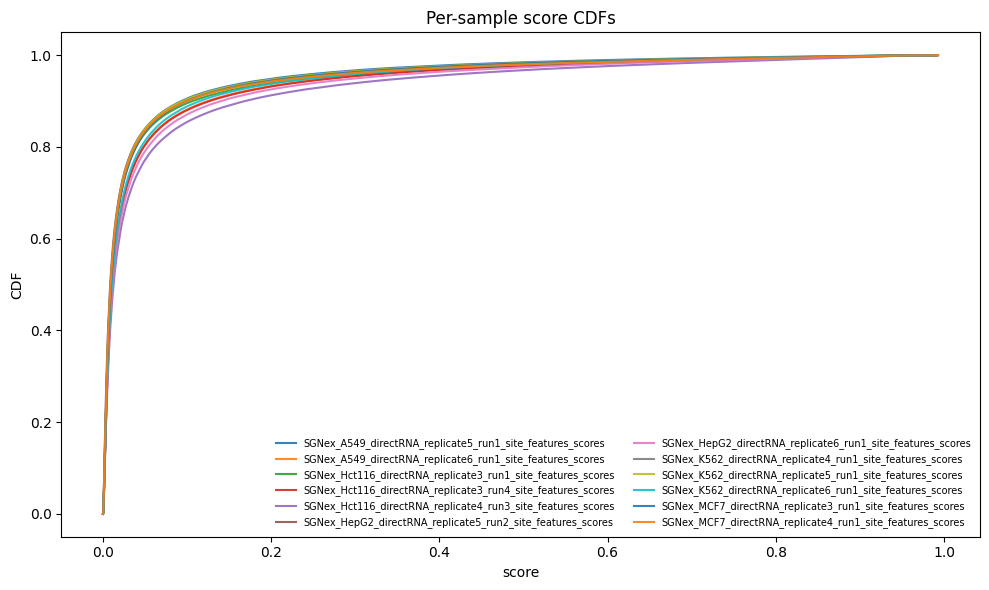

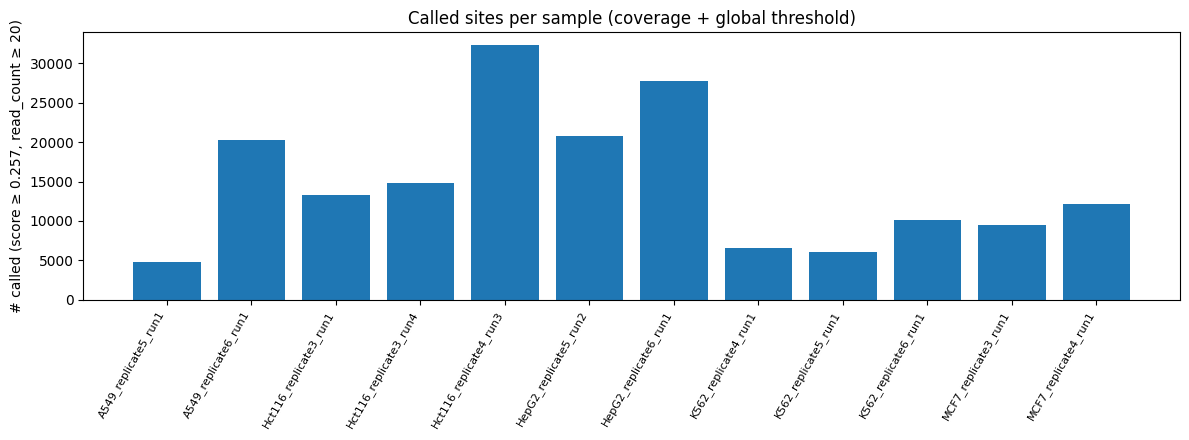

In [ ]:
import os, re, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastparquet import ParquetFile

SCORES_DIR    = "results"
SCORES_GLOB   = "*_scores.csv"

PARQUET_DIR   = "data/processed_parquet"
PARQUET_GLOB  = "*.parquet"

OUTPUT_DIR    = "data/task2_outputs2"

MIN_READ_COUNT = 20
GLOBAL_THR     = None
GLOBAL_THR_PCT = 0.95

os.makedirs(OUTPUT_DIR, exist_ok=True)

SAMPLE_RE = re.compile(
    r"""^SGNex_
        (?P<cell_line>[A-Za-z0-9\-]+)
        _directRNA_
        replicate(?P<rep>\d+)_
        run(?P<run>\d+)_
        site_features_scores$""", re.X
)

def parse_scores_name(path):
    base = os.path.splitext(os.path.basename(path))[0]
    m = SAMPLE_RE.match(base)
    meta = {"sample": base, "cell_line": None, "replicate": None, "run": None}
    if m:
        meta["cell_line"] = m.group("cell_line")
        meta["replicate"] = int(m.group("rep"))
        meta["run"] = int(m.group("run"))
    return meta

def read_scores_csv(path):
    usecols = ["transcript_id", "transcript_position", "score"]
    dtypes  = {"transcript_id":"string", "transcript_position":"int64", "score":"float64"}
    df = pd.read_csv(path, usecols=usecols, dtype=dtypes)
    return df

def find_matching_parquet(scores_sample: str, parquet_paths: list[str]) -> str | None:
    base = scores_sample
    candidates = [
        os.path.join(PARQUET_DIR, base.replace("_site_features_scores", "") + ".parquet"),
        os.path.join(PARQUET_DIR, base.replace("_site_features_scores", "_site_features") + ".parquet"),
        os.path.join(PARQUET_DIR, base.replace("_scores", "") + ".parquet"),
    ]
    for c in candidates:
        if os.path.exists(c):
            return c

    for p in parquet_paths:
        try:
            pf = ParquetFile(p)
            cols = set(pf.columns)
            if "sample" in cols:
                df_head = pd.read_parquet(p, columns=["sample"], engine="fastparquet", rows=1)
                ps = str(df_head["sample"].iloc[0])
                if ps == scores_sample:
                    return p
            stem = os.path.splitext(os.path.basename(p))[0]
            if stem in base or base in stem:
                return p
        except Exception:
            continue
    return None

def cdf_and_quantiles(score_files):
    rows = []
    pooled_scores = []

    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    for fp in score_files:
        meta = parse_scores_name(fp)
        df = read_scores_csv(fp)
        sc = df["score"].to_numpy(dtype=float)
        sc = sc[np.isfinite(sc)]
        pooled_scores.append(sc)

        srt = np.sort(sc)
        y = np.linspace(0, 1, len(srt), endpoint=True)
        ax.plot(srt, y, alpha=0.9, label=meta["sample"])

        qs = np.quantile(sc, [0.01,0.05,0.10,0.50,0.90,0.95,0.99])
        rows.append({
            "sample": meta["sample"],
            "cell_line": meta["cell_line"],
            "replicate": meta["replicate"],
            "run": meta["run"],
            "n_sites": int(len(sc)),
            "q01": float(qs[0]), "q05": float(qs[1]), "q10": float(qs[2]),
            "q50": float(qs[3]), "q90": float(qs[4]), "q95": float(qs[5]), "q99": float(qs[6]),
            "mean": float(sc.mean()), "std": float(sc.std()),
        })

    ax.set_xlabel("score"); ax.set_ylabel("CDF")
    ax.set_title("Per-sample score CDFs")
    ax.legend(fontsize=7, ncol=2, frameon=False)
    plt.tight_layout()
    fig_path = os.path.join(OUTPUT_DIR, "scores_cdf_overlay.png")
    plt.savefig(fig_path, dpi=180)
    print(f"Wrote: {fig_path}")

    qtab = pd.DataFrame(rows).sort_values(["cell_line","replicate","run","sample"])
    qtab_path = os.path.join(OUTPUT_DIR, "scores_quantiles.csv")
    qtab.to_csv(qtab_path, index=False)
    print(f"Wrote: {qtab_path}")

    pooled = np.concatenate(pooled_scores) if pooled_scores else np.array([])
    return pooled

def join_filter_calls(score_files, parquet_files, global_thr=None, global_thr_pct=0.95):
    if global_thr is None:
        pass

    calls_paths = []
    counts = []

    parquet_paths = sorted(parquet_files)

    for fp in score_files:
        meta = parse_scores_name(fp)
        sname = meta["sample"]

        df_scores = read_scores_csv(fp)

        ppath = find_matching_parquet(sname, parquet_paths)
        if ppath is None:
            print(f"[WARN] No matching parquet for {sname}; skipping coverage join.")
            df_join = df_scores.copy()
            df_join["read_count"] = np.nan
        else:
            pf = ParquetFile(ppath)
            want = [c for c in ["transcript_id","position","read_count","sample"] if c in pf.columns]
            df_cov = pd.read_parquet(ppath, columns=want, engine="fastparquet")
            df_join = df_scores.merge(
                df_cov,
                left_on=["transcript_id","transcript_position"],
                right_on=["transcript_id","position"],
                how="left",
                validate="m:1"
            )
            if "position" in df_join.columns:
                df_join = df_join.drop(columns=["position"])

        df_filt = df_join[df_join["read_count"].fillna(0) >= MIN_READ_COUNT].copy()

        if global_thr is None:
            raise RuntimeError("Global threshold not provided to step2_join_filter_calls().")
        df_calls = df_filt[df_filt["score"] >= global_thr].copy()

        outp = os.path.join(OUTPUT_DIR, f"coverage_filtered_calls_{sname}.csv")
        df_calls[["transcript_id","transcript_position","score","read_count"]].to_csv(outp, index=False)
        calls_paths.append(outp)

        counts.append({
            "sample": sname,
            "cell_line": meta["cell_line"],
            "replicate": meta["replicate"],
            "run": meta["run"],
            "n_after_cov": int(len(df_filt)),
            "n_called": int(len(df_calls)),
        })

    cnt = pd.DataFrame(counts).sort_values(["cell_line","replicate","run","sample"])
    cnt_path = os.path.join(OUTPUT_DIR, "coverage_filter_counts.csv")
    cnt.to_csv(cnt_path, index=False)
    print(f"Wrote: {cnt_path}")

    labels = cnt.apply(
        lambda r: (f"{r['cell_line']}_replicate{int(r['replicate'])}_run{int(r['run'])}"
                if pd.notna(r['cell_line']) and pd.notna(r['replicate']) and pd.notna(r['run'])
                else r['sample']),
        axis=1
    )

    fig, ax = plt.subplots(figsize=(12, 4.5))
    ax.bar(cnt["sample"], cnt["n_called"])
    ax.set_xticklabels(labels, rotation=60, ha="right", fontsize=8)
    ax.set_ylabel(f"# called (score ≥ {global_thr:.3f}, read_count ≥ {MIN_READ_COUNT})")
    ax.set_title("Called sites per sample (coverage + global threshold)")
    fig.tight_layout()
    figp = os.path.join(OUTPUT_DIR, "called_counts_global.png")
    fig.savefig(figp, dpi=180)
    print(f"Wrote: {figp}")

    return calls_paths

def consensus(calls_paths):
    def sample_from_calls_path(p):
        s = os.path.splitext(os.path.basename(p))[0].replace("coverage_filtered_calls_", "")
        return s

    all_calls = []
    for cp in calls_paths:
        sname = sample_from_calls_path(cp)
        meta = parse_scores_name(os.path.join(SCORES_DIR, sname + ".csv"))
        dfc = pd.read_csv(cp)
        dfc["sample"] = sname
        dfc["cell_line"] = meta["cell_line"]
        dfc["replicate"] = meta["replicate"]
        all_calls.append(dfc)

    if not all_calls:
        print("[INFO] No calls to build consensus from.")
        return

    calls = pd.concat(all_calls, ignore_index=True)

    for cl, sub in calls.groupby("cell_line", dropna=False):
        key = ["transcript_id","transcript_position"]
        supp = (sub.drop_duplicates(key + ["sample"])
                  .groupby(key)["sample"].nunique()
                  .reset_index(name="replicate_support"))
        mx = (sub.groupby(key)["score"].max().reset_index(name="max_score"))
        cons = (supp.merge(mx, on=key, how="left")
                    .sort_values(["replicate_support","max_score"], ascending=[False, False]))
        outp = os.path.join(OUTPUT_DIR, f"consensus_{cl if cl is not None else 'NA'}.csv")
        cons.to_csv(outp, index=False)
        print(f"Wrote: {outp}")

def main():
    score_files = sorted(glob.glob(os.path.join(SCORES_DIR, SCORES_GLOB)))
    if not score_files:
        raise FileNotFoundError(f"No files matched: {os.path.join(SCORES_DIR, SCORES_GLOB)}")
    parquet_files = sorted(glob.glob(os.path.join(PARQUET_DIR, PARQUET_GLOB)))

    pooled = cdf_and_quantiles(score_files)

    if GLOBAL_THR is not None:
        thr = float(GLOBAL_THR)
        print(f"Using fixed GLOBAL_THR = {thr}")
    else:
        if pooled.size == 0:
            raise RuntimeError("No scores found to compute pooled percentile threshold.")
        thr = float(np.quantile(pooled, GLOBAL_THR_PCT))
        print(f"Using pooled percentile GLOBAL_THR_PCT={GLOBAL_THR_PCT:.2f} -> threshold={thr:.6f}")

    calls_paths = join_filter_calls(score_files, parquet_files, global_thr=thr, global_thr_pct=GLOBAL_THR_PCT)

    consensus(calls_paths)

if __name__ == "__main__":
    main()

Wrote:
  data/task2_outputs2/site_matrix_by_cellline_masked.csv
  data/task2_outputs2/site_matrix_meta.csv
  data/task2_outputs2/diff_sites_ranked_with_cov.csv
  data/task2_outputs2/diff_sites_heatmap_masked.png


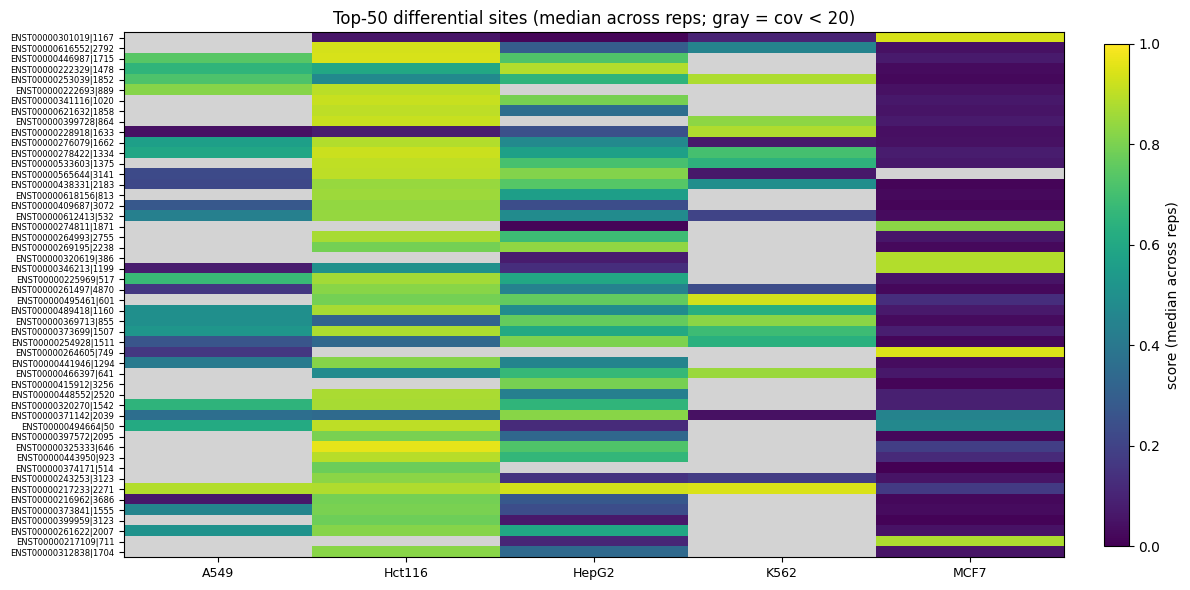

In [30]:
import os, re, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastparquet import ParquetFile, write as fp_write

SCORES_DIR    = "results"
SCORES_GLOB   = "*_scores.csv"
PARQUET_DIR   = "data/processed_parquet"
PARQUET_GLOB  = "*.parquet"
OUTPUT_DIR    = "data/task2_outputs2"

MIN_COV       = 20
TOP_N_HEATMAP = 50

os.makedirs(OUTPUT_DIR, exist_ok=True)
TMP_PERREP = os.path.join(OUTPUT_DIR, "per_rep_filtered.parquet")

SAMPLE_RE = re.compile(
    r"""^SGNex_(?P<cell_line>[A-Za-z0-9\-]+)_directRNA_"""
    r"""replicate(?P<rep>\d+)_run(?P<run>\d+)_site_features_scores$""", re.X
)

def parse_scores_name(path):
    base = os.path.splitext(os.path.basename(path))[0]
    m = SAMPLE_RE.match(base)
    meta = {"sample": base, "cell_line": None, "replicate": None, "run": None}
    if m:
        meta["cell_line"] = m.group("cell_line")
        meta["replicate"] = int(m.group("rep"))
        meta["run"] = int(m.group("run"))
    return meta

def list_parquets():
    return sorted(glob.glob(os.path.join(PARQUET_DIR, PARQUET_GLOB)))

def find_matching_parquet(scores_sample: str, parquet_paths):
    cands = [
        os.path.join(PARQUET_DIR, scores_sample.replace("_site_features_scores", "") + ".parquet"),
        os.path.join(PARQUET_DIR, scores_sample.replace("_site_features_scores", "_site_features") + ".parquet"),
        os.path.join(PARQUET_DIR, scores_sample.replace("_scores", "") + ".parquet"),
    ]
    for c in cands:
        if os.path.exists(c):
            return c
    for p in parquet_paths:
        try:
            pf = ParquetFile(p)
            if "sample" in pf.columns:
                head = pd.read_parquet(p, columns=["sample"], engine="fastparquet", rows=1)
                if str(head["sample"].iloc[0]) == scores_sample:
                    return p
        except Exception:
            pass
    return None

def write_append_parquet(path, df):
    if not os.path.exists(path):
        fp_write(path, df, compression="ZSTD", file_scheme="simple")
    else:
        fp_write(path, df, compression="ZSTD", append=True)

def main():
    score_files   = sorted(glob.glob(os.path.join(SCORES_DIR, SCORES_GLOB)))
    parquet_paths = list_parquets()
    if not score_files:
        raise FileNotFoundError("No score CSVs found")

    if os.path.exists(TMP_PERREP):
        os.remove(TMP_PERREP)

    for fp in score_files:
        meta = parse_scores_name(fp)
        sname, cl = meta["sample"], meta["cell_line"]

        df_sc = pd.read_csv(
            fp,
            usecols=["transcript_id","transcript_position","score"],
            dtype={"transcript_id":"string","transcript_position":"int64","score":"float64"},
        )

        ppath = find_matching_parquet(sname, parquet_paths)
        if ppath is None:
            print(f"[WARN] No matching parquet for {sname}; skipping (no coverage).")
            continue

        pf = ParquetFile(ppath)
        cols = [c for c in ["transcript_id","position","read_count"] if c in pf.columns]
        df_cov = pd.read_parquet(ppath, columns=cols, engine="fastparquet")

        df_cov["transcript_id"] = df_cov["transcript_id"].astype("string")
        df_cov["position"] = df_cov["position"].astype("int64")
        df = df_sc.merge(
            df_cov,
            left_on=["transcript_id","transcript_position"],
            right_on=["transcript_id","position"],
            how="left",
            validate="m:1"
        ).drop(columns=["position"])

        df = df.rename(columns={"read_count":"coverage"})
        df = df[np.isfinite(df["coverage"])]

        df["cell_line"] = cl
        df["sample"] = sname

        write_append_parquet(
            TMP_PERREP,
            df[["transcript_id","transcript_position","score","coverage","cell_line","sample"]]
        )

    if not os.path.exists(TMP_PERREP):
        raise RuntimeError("No per-replicate data with coverage was written.")

    per_rep = pd.read_parquet(TMP_PERREP, engine="fastparquet")

    good = per_rep[per_rep["coverage"] >= MIN_COV]

    med_scores = (good
        .groupby(["transcript_id","transcript_position","cell_line"], observed=True)["score"]
        .median()
        .reset_index(name="median_score"))

    cov_stats = (per_rep
        .groupby(["transcript_id","transcript_position","cell_line"], observed=True)["coverage"]
        .agg(rep_support=lambda x: int((x >= MIN_COV).sum()),
             min_cov="min",
             median_cov="median")
        .reset_index())

    per_line = cov_stats.merge(med_scores, on=["transcript_id","transcript_position","cell_line"], how="left")

    per_line.loc[per_line["min_cov"] < MIN_COV, "median_score"] = np.nan

    mat_scores = per_line.pivot(index=["transcript_id","transcript_position"],
                                columns="cell_line",
                                values="median_score")
    mat_rep_sup = per_line.pivot(index=["transcript_id","transcript_position"],
                                 columns="cell_line",
                                 values="rep_support").fillna(0).astype(int)
    mat_min_cov = per_line.pivot(index=["transcript_id","transcript_position"],
                                 columns="cell_line",
                                 values="min_cov")
    mat_med_cov = per_line.pivot(index=["transcript_id","transcript_position"],
                                 columns="cell_line",
                                 values="median_cov")

    present = mat_scores.notna().sum(axis=1)
    mat_scores = mat_scores[present >= 2]
    mat_rep_sup = mat_rep_sup.loc[mat_scores.index]
    mat_min_cov = mat_min_cov.loc[mat_scores.index]
    mat_med_cov = mat_med_cov.loc[mat_scores.index]

    site_range = mat_scores.max(axis=1, skipna=True) - mat_scores.min(axis=1, skipna=True)
    site_iqr   = mat_scores.quantile(0.75, axis=1, numeric_only=True) - mat_scores.quantile(0.25, axis=1, numeric_only=True)
    ranked_idx = site_range.sort_values(ascending=False).index
    ranked_df  = (mat_scores
                  .assign(range=site_range, IQR=site_iqr, n_cell_lines=mat_scores.notna().sum(axis=1))
                  .loc[ranked_idx])

    mat_scores.to_csv(os.path.join(OUTPUT_DIR, "site_matrix_by_cellline_masked.csv"))
    meta_out = pd.concat({
        "replicate_support": mat_rep_sup,
        "min_coverage": mat_min_cov,
        "median_coverage": mat_med_cov
    }, axis=1)
    meta_out.to_csv(os.path.join(OUTPUT_DIR, "site_matrix_meta.csv"))
    ranked_df.to_csv(os.path.join(OUTPUT_DIR, "diff_sites_ranked_with_cov.csv"))

    top = ranked_df.head(TOP_N_HEATMAP)
    X = top.drop(columns=["range","IQR","n_cell_lines"]).to_numpy(dtype=float)
    rows = [f"{tid}|{pos}" for tid, pos in top.index.tolist()]
    cols = mat_scores.columns.tolist()

    cmap = plt.get_cmap("viridis").copy()
    cmap.set_bad(color="lightgray")

    fig, ax = plt.subplots(figsize=(12, max(6, 0.02*len(rows))))
    im = ax.imshow(X, aspect="auto", interpolation="nearest", vmin=0, vmax=1, cmap=cmap)
    ax.set_yticks(range(len(rows))); ax.set_yticklabels(rows, fontsize=6)
    ax.set_xticks(range(len(cols))); ax.set_xticklabels(cols, fontsize=9)
    ax.set_title(f"Top-{len(rows)} differential sites (median across reps; gray = cov < {MIN_COV})")
    cbar = plt.colorbar(im, ax=ax, fraction=0.025, pad=0.04); cbar.set_label("score (median across reps)")
    fig.tight_layout()
    fig.savefig(os.path.join(OUTPUT_DIR, "diff_sites_heatmap_masked.png"), dpi=180)

    print("Wrote:",
          os.path.join(OUTPUT_DIR, "site_matrix_by_cellline_masked.csv"),
          os.path.join(OUTPUT_DIR, "site_matrix_meta.csv"),
          os.path.join(OUTPUT_DIR, "diff_sites_ranked_with_cov.csv"),
          os.path.join(OUTPUT_DIR, "diff_sites_heatmap_masked.png"),
          sep="\n  ")

if __name__ == "__main__":
    main()